In [6]:
from Bio import SeqIO, Seq
from Bio.SeqRecord import SeqRecord
import gffutils as gff
from BCBio import GFF
import copy

## Load reference data (genome sequences and annotation)

#### Current working dir.

In [29]:
pwd

'/home/grotec/Repositories/sbw25_newgenome/annotate/copy_from_GCA_9225v1_ASM922v1'

### Read the annotations

In [13]:
ref_gff = "../../reference_annotations/GCA_000009225.1_ASM922v1_genomic.gff"

In [30]:
with open(ref_gff, 'r') as fh:
    records = GFF.parse(fh)
    records = copy.deepcopy([rec for rec in records])

All in one record:

In [32]:
len(records)

1

### Get the annotations as features.

In [33]:
ref_features = records[0].features

In [34]:
len(ref_features)

26478

### Read the genome sequence.

In [57]:
ref_fasta = "/home/grotec/data/sync/sbw25/genbank2020/GCA_000009225.1_ASM922v1_genomic.fna"
ref_records = next(SeqIO.parse(open(ref_fasta, 'r'),'fasta'))

### Get the sequence proper.

In [57]:
ref_seq = ref_records.seq

## Write each feature as a separate fasta file. 
#### Write fw and rev. strands into sep. directories.

In [57]:
!mkdir reference_features/plus

In [57]:
!mkdir reference_features/minus

In [57]:
# Map to get the strand right.
int_to_strand = {-1:"minus", 1:"plus"}

### Loop over all features
* construct one record per feature
* insert id and annotations.
* write to appropriate strand directory.

In [57]:
for i,feature in enumerate(ref_features):
    seq = feature.extract(ref_seq)
    seq_record = SeqRecord(seq,
                           id=feature.id,
                           description="",
                           name="",
                           annotations=feature.qualifiers)
        
    strand = feature.location.strand
    
    with open('reference_features/{}/{}.fasta'.format(int_to_strand.get(feature.location.strand),feature.id), 'w') as fh:
        SeqIO.write([seq_record], fh, "fasta")

## Blast all features against new genome assembly

In [57]:
```shell
for fa in *.fasta; do echo $fa; blastn -task blastn -db ../Pseudomonas_fluorescens_SBW25_28C -query $fa -outfmt "10 qacc qstart qend sstart send sstrand nident pident mismatch positive gaps bitscore score evalue" -strand "minus" -evalue 1e-2 >> blastn_features_to_new_assembly_minus.csv; done
```

```shell
for fa in *.fasta; do echo $fa; blastn -task blastn -db ../Pseudomonas_fluorescens_SBW25_28C -query $fa -outfmt "10 qacc qstart qend sstart send sstrand nident pident mismatch positive gaps bitscore score evalue" -strand "plus" -evalue 1e-2 >> blastn_features_to_new_assembly_plus.csv; done
```

# Import alignment results

In [38]:
import pandas, numpy

## Plus strand

In [39]:
algn_plus = pandas.read_csv("reference_features/plus/blastn_features_to_new_assembly_plus.csv", index_col=0)

In [40]:
len(algn_plus)

475665

### Filter out pident < 100

In [493]:
algn_plus100 = algn_plus[algn_plus['pident']==100.0]

In [494]:
algn_plus100

qstart  qend   sstart     send sstrand  nident  \
id                                                                              
gene-PFLU_0001                      1  1506        1     1506    plus    1506   
gene-PFLU_0002                      1  1104     1545     2648    plus    1104   
gene-PFLU_0003                      1  1104     2669     3772    plus    1104   
gene-PFLU_0004                      1  2418     3777     6194    plus    2418   
gene-PFLU_0006                      1   957     7284     8240    plus     957   
...                               ...   ...      ...      ...     ...     ...   
rna-AM181176.4:885528..885600       8    26  2029209  2029227    plus      19   
rna-AM181176.4:885528..885600       8    26  2376022  2376040    plus      19   
rna-AM181176.4:885698..885771       1    74   885447   885520    plus      74   
rna-AM181176.4:885698..885771       1    74   885699   885772    plus      74   
rna-AM181176.4:894195..894267       1    73   894196   894268    plus      73   

                               pident  mismatch  positive  gaps  bitscore  \
id                                                                          
gene-PFLU_0001                  100.0         0      1506     0    2717.0   
gene-PFLU_0002                  100.0         0      1104     0    1992.0   
gene-PFLU_0003                  100.0         0      1104     0    1992.0   
gene-PFLU_0004                  100.0         0      2418     0    4361.0   
gene-PFLU_0006                  100.0         0       957     0    1727.0   
...                               ...       ...       ...   ...       ...   
rna-AM181176.4:885528..885600   100.0         0        19     0      35.6   
rna-AM181176.4:885528..885600   100.0         0        19     0      35.6   
rna-AM181176.4:885698..885771   100.0         0        74     0     134.0   
rna-AM181176.4:885698..885771   100.0         0        74     0     134.0   
rna-AM181176.4:894195..894267   100.0         0        73     0     132.0   

                               score        evalue  
id                                                  
gene-PFLU_0001                  3012  0.000000e+00  
gene-PFLU_0002                  2208  0.000000e+00  
gene-PFLU_0003                  2208  0.000000e+00  
gene-PFLU_0004                  4836  0.000000e+00  
gene-PFLU_0006                  1914  0.000000e+00  
...                              ...           ...  
rna-AM181176.4:885528..885600     38  7.000000e-03  
rna-AM181176.4:885528..885600     38  7.000000e-03  
rna-AM181176.4:885698..885771    148  1.000000e-32  
rna-AM181176.4:885698..885771    148  1.000000e-32  
rna-AM181176.4:894195..894267    146  3.000000e-32  

[108853 rows x 13 columns]

## Genes

In [495]:
gene_plus = algn_plus100.loc[algn_plus100.index.str.startswith("gene")]

In [496]:
gene_plus

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0001       1  1506        1     1506    plus    1506   100.0   
gene-PFLU_0002       1  1104     1545     2648    plus    1104   100.0   
gene-PFLU_0003       1  1104     2669     3772    plus    1104   100.0   
gene-PFLU_0004       1  2418     3777     6194    plus    2418   100.0   
gene-PFLU_0006       1   957     7284     8240    plus     957   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_6111       1  5805  6688924  6694728    plus    5805   100.0   
gene-PFLU_6112       1  2301  6694709  6697009    plus    2301   100.0   
gene-PFLU_6130       1   519  6713810  6714328    plus     519   100.0   
gene-PFLU_6131       1   945  6714328  6715272    plus     945   100.0   
gene-PFLU_6132       1  2439  6715365  6717803    plus    2439   100.0   

                mismatch  positive  gaps  bitscore  score  evalue  
id                                                                 
gene-PFLU_0001         0      1506     0    2717.0   3012     0.0  
gene-PFLU_0002         0      1104     0    1992.0   2208     0.0  
gene-PFLU_0003         0      1104     0    1992.0   2208     0.0  
gene-PFLU_0004         0      2418     0    4361.0   4836     0.0  
gene-PFLU_0006         0       957     0    1727.0   1914     0.0  
...                  ...       ...   ...       ...    ...     ...  
gene-PFLU_6111         0      5805     0   10469.0  11610     0.0  
gene-PFLU_6112         0      2301     0    4150.0   4602     0.0  
gene-PFLU_6130         0       519     0     937.0   1038     0.0  
gene-PFLU_6131         0       945     0    1705.0   1890     0.0  
gene-PFLU_6132         0      2439     0    4399.0   4878     0.0  

[3050 rows x 13 columns]

### Discard duplicates. From each set of duplicates, keep the first

In [497]:
gene_plus.loc[gene_plus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0013       1   888    15784    16671    plus     888   100.0   
gene-PFLU_0013     522   542  5468445  5468465    plus      21   100.0   
gene-PFLU_0049       1   276    49251    49526    plus     276   100.0   
gene-PFLU_0049      52    71  4477981  4478000    plus      20   100.0   
gene-PFLU_0368       1  1410   407245   408654    plus    1410   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_5821      93   114  6161322  6161343    plus      22   100.0   
gene-PFLU_6036       1   891  6603976  6604866    plus     891   100.0   
gene-PFLU_6036     411   435  6183048  6183072    plus      25   100.0   
gene-PFLU_6067       1   681  6640415  6641095    plus     681   100.0   
gene-PFLU_6067     259   279  6673689  6673709    plus      21   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
gene-PFLU_0013         0       888     0    1602.0   1776   0.000000e+00  
gene-PFLU_0013         0        21     0      39.2     42   9.000000e-03  
gene-PFLU_0049         0       276     0     499.0    552  1.000000e-141  
gene-PFLU_0049         0        20     0      37.4     40   1.000000e-02  
gene-PFLU_0368         0      1410     0    2544.0   2820   0.000000e+00  
...                  ...       ...   ...       ...    ...            ...  
gene-PFLU_5821         0        22     0      41.0     44   2.000000e-03  
gene-PFLU_6036         0       891     0    1608.0   1782   0.000000e+00  
gene-PFLU_6036         0        25     0      46.4     50   6.000000e-05  
gene-PFLU_6067         0       681     0    1229.0   1362   0.000000e+00  
gene-PFLU_6067         0        21     0      39.2     42   7.000000e-03  

[205 rows x 13 columns]

In all groups of identical ids, keep the first one. In this way, the pflu ids keep their order.

In [498]:
gene_plus_unique = gene_plus.loc[numpy.logical_not(gene_plus.index.duplicated(keep='first'))]

In [499]:
gene_plus_unique

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0001       1  1506        1     1506    plus    1506   100.0   
gene-PFLU_0002       1  1104     1545     2648    plus    1104   100.0   
gene-PFLU_0003       1  1104     2669     3772    plus    1104   100.0   
gene-PFLU_0004       1  2418     3777     6194    plus    2418   100.0   
gene-PFLU_0006       1   957     7284     8240    plus     957   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_6111       1  5805  6688924  6694728    plus    5805   100.0   
gene-PFLU_6112       1  2301  6694709  6697009    plus    2301   100.0   
gene-PFLU_6130       1   519  6713810  6714328    plus     519   100.0   
gene-PFLU_6131       1   945  6714328  6715272    plus     945   100.0   
gene-PFLU_6132       1  2439  6715365  6717803    plus    2439   100.0   

                mismatch  positive  gaps  bitscore  score  evalue  
id                                                                 
gene-PFLU_0001         0      1506     0    2717.0   3012     0.0  
gene-PFLU_0002         0      1104     0    1992.0   2208     0.0  
gene-PFLU_0003         0      1104     0    1992.0   2208     0.0  
gene-PFLU_0004         0      2418     0    4361.0   4836     0.0  
gene-PFLU_0006         0       957     0    1727.0   1914     0.0  
...                  ...       ...   ...       ...    ...     ...  
gene-PFLU_6111         0      5805     0   10469.0  11610     0.0  
gene-PFLU_6112         0      2301     0    4150.0   4602     0.0  
gene-PFLU_6130         0       519     0     937.0   1038     0.0  
gene-PFLU_6131         0       945     0    1705.0   1890     0.0  
gene-PFLU_6132         0      2439     0    4399.0   4878     0.0  

[2902 rows x 13 columns]

## Gene subfeatures

In [500]:
gene_plus_sub  = algn_plus100.loc[algn_plus100.index.str.startswith("id-PFLU")]

In [501]:
gene_plus_sub

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
id-PFLU_0001-2       1    24      616      639    plus      24   100.0   
id-PFLU_0001-3       1   210     1225     1434    plus     210   100.0   
id-PFLU_0001-4       1    60     1375     1434    plus      60   100.0   
id-PFLU_0001         1   657      496     1152    plus     657   100.0   
id-PFLU_0002-2       1   348     1929     2276    plus     348   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6130         1   201  6713858  6714058    plus     201   100.0   
id-PFLU_6131         1   285  6714640  6714924    plus     285   100.0   
id-PFLU_6132-2       1   324  6715842  6716165    plus     324   100.0   
id-PFLU_6132-3       1   720  6717081  6717800    plus     720   100.0   
id-PFLU_6132         1   156  6715557  6715712    plus     156   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
id-PFLU_0001-2         0        24     0      44.6     48   1.000000e-06  
id-PFLU_0001-3         0       210     0     379.0    420  5.000000e-106  
id-PFLU_0001-4         0        60     0     109.0    120   3.000000e-25  
id-PFLU_0001           0       657     0    1186.0   1314   0.000000e+00  
id-PFLU_0002-2         0       348     0     628.0    696  1.000000e-180  
...                  ...       ...   ...       ...    ...            ...  
id-PFLU_6130           0       201     0     363.0    402  4.000000e-101  
id-PFLU_6131           0       285     0     515.0    570  1.000000e-146  
id-PFLU_6132-2         0       324     0     585.0    648  1.000000e-167  
id-PFLU_6132-3         0       720     0    1299.0   1440   0.000000e+00  
id-PFLU_6132           0       156     0     282.0    312   8.000000e-77  

[8659 rows x 13 columns]

In [502]:
gene_plus_sub.loc[gene_plus_sub.index.duplicated(keep=False)]

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                         
id-PFLU_0007_3         1    60     9237     9296    plus      60   100.0   
id-PFLU_0007_3        21    39  5512737  5512755    plus      19   100.0   
id-PFLU_0013           1   831    15811    16641    plus     831   100.0   
id-PFLU_0013         495   515  5468445  5468465    plus      21   100.0   
id-PFLU_0033_7         1    60    36639    36698    plus      60   100.0   
...                  ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6067-2        10    30  6673689  6673709    plus      21   100.0   
id-PFLU_6076           1    69  6654166  6654234    plus      69   100.0   
id-PFLU_6076          13    31  4124329  4124347    plus      19   100.0   
id-PFLU_6090-2_6       1    69  6667851  6667919    plus      69   100.0   
id-PFLU_6090-2_6      14    33  4738241  4738260    plus      20   100.0   

                  mismatch  positive  gaps  bitscore  score        evalue  
id                                                                         
id-PFLU_0007_3           0        60     0     109.0    120  3.000000e-25  
id-PFLU_0007_3           0        19     0      35.6     38  5.000000e-03  
id-PFLU_0013             0       831     0    1499.0   1662  0.000000e+00  
id-PFLU_0013             0        21     0      39.2     42  9.000000e-03  
id-PFLU_0033_7           0        60     0     109.0    120  3.000000e-25  
...                    ...       ...   ...       ...    ...           ...  
id-PFLU_6067-2           0        21     0      39.2     42  2.000000e-03  
id-PFLU_6076             0        69     0     125.0    138  5.000000e-30  
id-PFLU_6076             0        19     0      35.6     38  6.000000e-03  
id-PFLU_6090-2_6         0        69     0     125.0    138  5.000000e-30  
id-PFLU_6090-2_6         0        20     0      37.4     40  2.000000e-03  

[721 rows x 13 columns]

In [503]:
gene_plus_sub_unique = gene_plus_sub.loc[numpy.logical_not(gene_plus_sub.index.duplicated(keep='first'))]

In [504]:
gene_plus_sub_unique

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
id-PFLU_0001-2       1    24      616      639    plus      24   100.0   
id-PFLU_0001-3       1   210     1225     1434    plus     210   100.0   
id-PFLU_0001-4       1    60     1375     1434    plus      60   100.0   
id-PFLU_0001         1   657      496     1152    plus     657   100.0   
id-PFLU_0002-2       1   348     1929     2276    plus     348   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6130         1   201  6713858  6714058    plus     201   100.0   
id-PFLU_6131         1   285  6714640  6714924    plus     285   100.0   
id-PFLU_6132-2       1   324  6715842  6716165    plus     324   100.0   
id-PFLU_6132-3       1   720  6717081  6717800    plus     720   100.0   
id-PFLU_6132         1   156  6715557  6715712    plus     156   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
id-PFLU_0001-2         0        24     0      44.6     48   1.000000e-06  
id-PFLU_0001-3         0       210     0     379.0    420  5.000000e-106  
id-PFLU_0001-4         0        60     0     109.0    120   3.000000e-25  
id-PFLU_0001           0       657     0    1186.0   1314   0.000000e+00  
id-PFLU_0002-2         0       348     0     628.0    696  1.000000e-180  
...                  ...       ...   ...       ...    ...            ...  
id-PFLU_6130           0       201     0     363.0    402  4.000000e-101  
id-PFLU_6131           0       285     0     515.0    570  1.000000e-146  
id-PFLU_6132-2         0       324     0     585.0    648  1.000000e-167  
id-PFLU_6132-3         0       720     0    1299.0   1440   0.000000e+00  
id-PFLU_6132           0       156     0     282.0    312   8.000000e-77  

[8187 rows x 13 columns]

## Other subfeatures

In [505]:
misc_plus  = algn_plus100.loc[algn_plus100.index.str.startswith("id-AM")]

In [506]:
misc_plus

qstart   qend   sstart     send sstrand  \
id                                                                        
id-AM181176.4:1001373..1001465       1     93  1001583  1001675    plus   
id-AM181176.4:1001373..1001465      44     64  4331246  4331266    plus   
id-AM181176.4:1001373..1001465      74     93  2465053  2465072    plus   
id-AM181176.4:1002303..1002333       1     31  1002513  1002543    plus   
id-AM181176.4:1004997..1005021       1     25  1005207  1005231    plus   
...                                ...    ...      ...      ...     ...   
id-AM181176.4:968638..968665         7     24  4387198  4387215    plus   
id-AM181176.4:968638..968665         7     24  5445291  5445308    plus   
id-AM181176.4:968666..1001372        1  32707   968875  1001582    plus   
id-AM181176.4:968666..1001372     4846   4869  3629793  3629816    plus   
id-AM181176.4:985333..985355         1     23   985543   985565    plus   

                                nident  pident  mismatch  positive  gaps  \
id                                                                         
id-AM181176.4:1001373..1001465      93   100.0         0        93     0   
id-AM181176.4:1001373..1001465      21   100.0         0        21     0   
id-AM181176.4:1001373..1001465      20   100.0         0        20     0   
id-AM181176.4:1002303..1002333      31   100.0         0        31     0   
id-AM181176.4:1004997..1005021      25   100.0         0        25     0   
...                                ...     ...       ...       ...   ...   
id-AM181176.4:968638..968665        18   100.0         0        18     0   
id-AM181176.4:968638..968665        18   100.0         0        18     0   
id-AM181176.4:968666..1001372    32707   100.0         0     32707     1   
id-AM181176.4:968666..1001372       24   100.0         0        24     0   
id-AM181176.4:985333..985355        23   100.0         0        23     0   

                                bitscore  score        evalue  
id                                                             
id-AM181176.4:1001373..1001465     168.0    186  6.000000e-43  
id-AM181176.4:1001373..1001465      39.2     42  8.000000e-04  
id-AM181176.4:1001373..1001465      37.4     40  3.000000e-03  
id-AM181176.4:1002303..1002333      57.2     62  4.000000e-10  
id-AM181176.4:1004997..1005021      46.4     50  4.000000e-07  
...                                  ...    ...           ...  
id-AM181176.4:968638..968665        33.7     36  4.000000e-03  
id-AM181176.4:968638..968665        33.7     36  4.000000e-03  
id-AM181176.4:968666..1001372    58976.0  65406  0.000000e+00  
id-AM181176.4:968666..1001372       44.6     48  8.000000e-03  
id-AM181176.4:985333..985355        42.8     46  5.000000e-06  

[97038 rows x 13 columns]

In [507]:
misc_plus.loc[misc_plus.index.duplicated(keep=False)]

qstart   qend   sstart     send sstrand  \
id                                                                        
id-AM181176.4:1001373..1001465       1     93  1001583  1001675    plus   
id-AM181176.4:1001373..1001465      44     64  4331246  4331266    plus   
id-AM181176.4:1001373..1001465      74     93  2465053  2465072    plus   
id-AM181176.4:1013126..1013220       1     95  1013336  1013430    plus   
id-AM181176.4:1013126..1013220       5     34  2891736  2891765    plus   
...                                ...    ...      ...      ...     ...   
id-AM181176.4:968638..968665         5     22  2206764  2206781    plus   
id-AM181176.4:968638..968665         7     24  4387198  4387215    plus   
id-AM181176.4:968638..968665         7     24  5445291  5445308    plus   
id-AM181176.4:968666..1001372        1  32707   968875  1001582    plus   
id-AM181176.4:968666..1001372     4846   4869  3629793  3629816    plus   

                                nident  pident  mismatch  positive  gaps  \
id                                                                         
id-AM181176.4:1001373..1001465      93   100.0         0        93     0   
id-AM181176.4:1001373..1001465      21   100.0         0        21     0   
id-AM181176.4:1001373..1001465      20   100.0         0        20     0   
id-AM181176.4:1013126..1013220      95   100.0         0        95     0   
id-AM181176.4:1013126..1013220      30   100.0         0        30     0   
...                                ...     ...       ...       ...   ...   
id-AM181176.4:968638..968665        18   100.0         0        18     0   
id-AM181176.4:968638..968665        18   100.0         0        18     0   
id-AM181176.4:968638..968665        18   100.0         0        18     0   
id-AM181176.4:968666..1001372    32707   100.0         0     32707     1   
id-AM181176.4:968666..1001372       24   100.0         0        24     0   

                                bitscore  score        evalue  
id                                                             
id-AM181176.4:1001373..1001465     168.0    186  6.000000e-43  
id-AM181176.4:1001373..1001465      39.2     42  8.000000e-04  
id-AM181176.4:1001373..1001465      37.4     40  3.000000e-03  
id-AM181176.4:1013126..1013220     172.0    190  5.000000e-44  
id-AM181176.4:1013126..1013220      55.4     60  1.000000e-08  
...                                  ...    ...           ...  
id-AM181176.4:968638..968665        33.7     36  4.000000e-03  
id-AM181176.4:968638..968665        33.7     36  4.000000e-03  
id-AM181176.4:968638..968665        33.7     36  4.000000e-03  
id-AM181176.4:968666..1001372    58976.0  65406  0.000000e+00  
id-AM181176.4:968666..1001372       44.6     48  8.000000e-03  

[96548 rows x 13 columns]

In [508]:
misc_plus_unique = misc_plus.loc[numpy.logical_not(misc_plus.index.duplicated(keep='first'))]

In [509]:
misc_plus_unique

qstart   qend   sstart     send sstrand  \
id                                                                        
id-AM181176.4:1001373..1001465       1     93  1001583  1001675    plus   
id-AM181176.4:1002303..1002333       1     31  1002513  1002543    plus   
id-AM181176.4:1004997..1005021       1     25  1005207  1005231    plus   
id-AM181176.4:1008696..1008719       1     24  1008906  1008929    plus   
id-AM181176.4:1013126..1013220       1     95  1013336  1013430    plus   
...                                ...    ...      ...      ...     ...   
id-AM181176.4:966597..966623         1     27   966806   966832    plus   
id-AM181176.4:968574..968665         1     92   968783   968874    plus   
id-AM181176.4:968638..968665         1     28   968847   968874    plus   
id-AM181176.4:968666..1001372        1  32707   968875  1001582    plus   
id-AM181176.4:985333..985355         1     23   985543   985565    plus   

                                nident  pident  mismatch  positive  gaps  \
id                                                                         
id-AM181176.4:1001373..1001465      93   100.0         0        93     0   
id-AM181176.4:1002303..1002333      31   100.0         0        31     0   
id-AM181176.4:1004997..1005021      25   100.0         0        25     0   
id-AM181176.4:1008696..1008719      24   100.0         0        24     0   
id-AM181176.4:1013126..1013220      95   100.0         0        95     0   
...                                ...     ...       ...       ...   ...   
id-AM181176.4:966597..966623        27   100.0         0        27     0   
id-AM181176.4:968574..968665        92   100.0         0        92     0   
id-AM181176.4:968638..968665        28   100.0         0        28     0   
id-AM181176.4:968666..1001372    32707   100.0         0     32707     1   
id-AM181176.4:985333..985355        23   100.0         0        23     0   

                                bitscore  score        evalue  
id                                                             
id-AM181176.4:1001373..1001465     168.0    186  6.000000e-43  
id-AM181176.4:1002303..1002333      57.2     62  4.000000e-10  
id-AM181176.4:1004997..1005021      46.4     50  4.000000e-07  
id-AM181176.4:1008696..1008719      44.6     48  1.000000e-06  
id-AM181176.4:1013126..1013220     172.0    190  5.000000e-44  
...                                  ...    ...           ...  
id-AM181176.4:966597..966623        50.0     54  5.000000e-08  
id-AM181176.4:968574..968665       167.0    184  2.000000e-42  
id-AM181176.4:968638..968665        51.8     56  2.000000e-08  
id-AM181176.4:968666..1001372    58976.0  65406  0.000000e+00  
id-AM181176.4:985333..985355        42.8     46  5.000000e-06  

[1884 rows x 13 columns]

## rna

In [510]:
rna_plus  = algn_plus100.loc[algn_plus100.index.str.startswith("rna-")]

In [511]:
rna_plus

qstart  qend   sstart     send sstrand  \
id                                                                        
rna-AM181176.4:1040892..1041184       1   293  1041102  1041394    plus   
rna-AM181176.4:119713..121250         1  1538   119714   121251    plus   
rna-AM181176.4:119713..121250         1  1538   768526   770063    plus   
rna-AM181176.4:119713..121250         1  1538  2235130  2236667    plus   
rna-AM181176.4:121338..121411         1    74   121339   121412    plus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:885528..885600         8    26  2029209  2029227    plus   
rna-AM181176.4:885528..885600         8    26  2376022  2376040    plus   
rna-AM181176.4:885698..885771         1    74   885447   885520    plus   
rna-AM181176.4:885698..885771         1    74   885699   885772    plus   
rna-AM181176.4:894195..894267         1    73   894196   894268    plus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
rna-AM181176.4:1040892..1041184     293   100.0         0       293     0   
rna-AM181176.4:119713..121250      1538   100.0         0      1538     0   
rna-AM181176.4:119713..121250      1538   100.0         0      1538     0   
rna-AM181176.4:119713..121250      1538   100.0         0      1538     0   
rna-AM181176.4:121338..121411        74   100.0         0        74     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:885528..885600        19   100.0         0        19     0   
rna-AM181176.4:885528..885600        19   100.0         0        19     0   
rna-AM181176.4:885698..885771        74   100.0         0        74     0   
rna-AM181176.4:885698..885771        74   100.0         0        74     0   
rna-AM181176.4:894195..894267        73   100.0         0        73     0   

                                 bitscore  score         evalue  
id                                                               
rna-AM181176.4:1040892..1041184     529.0    586  6.000000e-151  
rna-AM181176.4:119713..121250      2774.0   3076   0.000000e+00  
rna-AM181176.4:119713..121250      2774.0   3076   0.000000e+00  
rna-AM181176.4:119713..121250      2774.0   3076   0.000000e+00  
rna-AM181176.4:121338..121411       134.0    148   1.000000e-32  
...                                   ...    ...            ...  
rna-AM181176.4:885528..885600        35.6     38   7.000000e-03  
rna-AM181176.4:885528..885600        35.6     38   7.000000e-03  
rna-AM181176.4:885698..885771       134.0    148   1.000000e-32  
rna-AM181176.4:885698..885771       134.0    148   1.000000e-32  
rna-AM181176.4:894195..894267       132.0    146   3.000000e-32  

[106 rows x 13 columns]

In [512]:
rna_plus.loc[rna_plus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  nident  \
id                                                                              
rna-AM181176.4:119713..121250       1  1538   119714   121251    plus    1538   
rna-AM181176.4:119713..121250       1  1538   768526   770063    plus    1538   
rna-AM181176.4:119713..121250       1  1538  2235130  2236667    plus    1538   
rna-AM181176.4:121338..121411       1    74   121339   121412    plus      74   
rna-AM181176.4:121338..121411       1    74   770151   770224    plus      74   
...                               ...   ...      ...      ...     ...     ...   
rna-AM181176.4:885528..885600       8    26  2028950  2028968    plus      19   
rna-AM181176.4:885528..885600       8    26  2029209  2029227    plus      19   
rna-AM181176.4:885528..885600       8    26  2376022  2376040    plus      19   
rna-AM181176.4:885698..885771       1    74   885447   885520    plus      74   
rna-AM181176.4:885698..885771       1    74   885699   885772    plus      74   

                               pident  mismatch  positive  gaps  bitscore  \
id                                                                          
rna-AM181176.4:119713..121250   100.0         0      1538     0    2774.0   
rna-AM181176.4:119713..121250   100.0         0      1538     0    2774.0   
rna-AM181176.4:119713..121250   100.0         0      1538     0    2774.0   
rna-AM181176.4:121338..121411   100.0         0        74     0     134.0   
rna-AM181176.4:121338..121411   100.0         0        74     0     134.0   
...                               ...       ...       ...   ...       ...   
rna-AM181176.4:885528..885600   100.0         0        19     0      35.6   
rna-AM181176.4:885528..885600   100.0         0        19     0      35.6   
rna-AM181176.4:885528..885600   100.0         0        19     0      35.6   
rna-AM181176.4:885698..885771   100.0         0        74     0     134.0   
rna-AM181176.4:885698..885771   100.0         0        74     0     134.0   

                               score        evalue  
id                                                  
rna-AM181176.4:119713..121250   3076  0.000000e+00  
rna-AM181176.4:119713..121250   3076  0.000000e+00  
rna-AM181176.4:119713..121250   3076  0.000000e+00  
rna-AM181176.4:121338..121411    148  1.000000e-32  
rna-AM181176.4:121338..121411    148  1.000000e-32  
...                              ...           ...  
rna-AM181176.4:885528..885600     38  7.000000e-03  
rna-AM181176.4:885528..885600     38  7.000000e-03  
rna-AM181176.4:885528..885600     38  7.000000e-03  
rna-AM181176.4:885698..885771    148  1.000000e-32  
rna-AM181176.4:885698..885771    148  1.000000e-32  

[87 rows x 13 columns]

In [513]:
rna_plus_unique = rna_plus.loc[numpy.logical_not(rna_plus.index.duplicated(keep='first'))]

In [514]:
rna_plus.loc["rna-AM181176.4:1299177..1299340"]

qstart            1
qend            164
sstart      1299387
send        1299550
sstrand        plus
nident          164
pident        100.0
mismatch          0
positive        164
gaps              0
bitscore      297.0
score           328
evalue          0.0
Name: rna-AM181176.4:1299177..1299340, dtype: object

In [515]:
rna_plus_unique

qstart  qend   sstart     send sstrand  \
id                                                                        
rna-AM181176.4:1040892..1041184       1   293  1041102  1041394    plus   
rna-AM181176.4:119713..121250         1  1538   119714   121251    plus   
rna-AM181176.4:121338..121411         1    74   121339   121412    plus   
rna-AM181176.4:121445..121517         1    73   121446   121518    plus   
rna-AM181176.4:121764..124664         1  2901   121765   124665    plus   
rna-AM181176.4:124811..124930         1   120   124812   124931    plus   
rna-AM181176.4:125036..125155         1   120   125037   125156    plus   
rna-AM181176.4:1299177..1299340       1   164  1299387  1299550    plus   
rna-AM181176.4:1624965..1625051       1    87  1625175  1625261    plus   
rna-AM181176.4:2028653..2028725       1    73  2028863  2028935    plus   
rna-AM181176.4:2028733..2028805       1    73  2028943  2029015    plus   
rna-AM181176.4:2028913..2028985       1    73  2028863  2028935    plus   
rna-AM181176.4:2028992..2029064       1    73  2028943  2029015    plus   
rna-AM181176.4:2049983..2050055       1    73  2050193  2050265    plus   
rna-AM181176.4:2050078..2050151       1    74  2050288  2050361    plus   
rna-AM181176.4:2050331..2050403       1    73  2050193  2050265    plus   
rna-AM181176.4:2050426..2050499       1    74  2050288  2050361    plus   
rna-AM181176.4:2234920..2236457       1  1538   119714   121251    plus   
rna-AM181176.4:2236545..2236618       1    74   121339   121412    plus   
rna-AM181176.4:2236652..2236724       1    73   121446   121518    plus   
rna-AM181176.4:2236971..2239871       1  2901   121765   124665    plus   
rna-AM181176.4:2240018..2240137       1   120   124812   124931    plus   
rna-AM181176.4:2375805..2375877       1    73  2028943  2029015    plus   
rna-AM181176.4:2944182..2944381       1   200  2944392  2944591    plus   
rna-AM181176.4:3221272..3221355       1    84  3221482  3221565    plus   
rna-AM181176.4:4296931..4297080       1   150  4296791  4296940    plus   
rna-AM181176.4:4663279..4663474       1   196  4663139  4663334    plus   
rna-AM181176.4:5226269..5226438       1   170  5226129  5226298    plus   
rna-AM181176.4:5488630..5488703       1    74  5488490  5488563    plus   
rna-AM181176.4:5489022..5489095       1    74  5488490  5488563    plus   
rna-AM181176.4:5577099..5577180       1    82  5576959  5577040    plus   
rna-AM181176.4:557909..558014         1   106   557910   558015    plus   
rna-AM181176.4:5717037..5717156       1   120  5716897  5717016    plus   
rna-AM181176.4:5720717..5722254       1  1538  5720577  5722114    plus   
rna-AM181176.4:5735279..5735433       1   155  5735139  5735293    plus   
rna-AM181176.4:5798308..5798701       1   394  5798168  5798561    plus   
rna-AM181176.4:6068492..6068611       1   120  6068352  6068471    plus   
rna-AM181176.4:6068758..6071658       1  2901  5717163  5720063    plus   
rna-AM181176.4:6072180..6073709       1  1530  5720585  5722114    plus   
rna-AM181176.4:6129999..6130072       1    74  6129859  6129932    plus   
rna-AM181176.4:6438562..6438739       1   178  6438422  6438599    plus   
rna-AM181176.4:768525..770062         1  1538   119714   121251    plus   
rna-AM181176.4:770150..770223         1    74   121339   121412    plus   
rna-AM181176.4:770257..770329         1    73   121446   121518    plus   
rna-AM181176.4:770576..773476         1  2901   121765   124665    plus   
rna-AM181176.4:773623..773742         1   120   124812   124931    plus   
rna-AM181176.4:885361..885433         1    73   885362   885434    plus   
rna-AM181176.4:885446..885519         1    74   885447   885520    plus   
rna-AM181176.4:885528..885600         1    73   885529   885601    plus   
rna-AM181176.4:885698..885771         1    74   885447   885520    plus   
rna-AM181176.4:894195..894267         1    73   894196   894268    plus   

                                 nident  pident  mismatch

In [516]:
len(rna_plus_unique)

51

In [517]:
plus_unique = pandas.concat([gene_plus_unique, gene_plus_sub_unique, misc_plus_unique, rna_plus_unique], axis=0)

In [518]:
plus_unique

qstart  qend  sstart    send sstrand  nident  \
id                                                                            
gene-PFLU_0001                      1  1506       1    1506    plus    1506   
gene-PFLU_0002                      1  1104    1545    2648    plus    1104   
gene-PFLU_0003                      1  1104    2669    3772    plus    1104   
gene-PFLU_0004                      1  2418    3777    6194    plus    2418   
gene-PFLU_0006                      1   957    7284    8240    plus     957   
...                               ...   ...     ...     ...     ...     ...   
rna-AM181176.4:885361..885433       1    73  885362  885434    plus      73   
rna-AM181176.4:885446..885519       1    74  885447  885520    plus      74   
rna-AM181176.4:885528..885600       1    73  885529  885601    plus      73   
rna-AM181176.4:885698..885771       1    74  885447  885520    plus      74   
rna-AM181176.4:894195..894267       1    73  894196  894268    plus      73   

                               pident  mismatch  positive  gaps  bitscore  \
id                                                                          
gene-PFLU_0001                  100.0         0      1506     0    2717.0   
gene-PFLU_0002                  100.0         0      1104     0    1992.0   
gene-PFLU_0003                  100.0         0      1104     0    1992.0   
gene-PFLU_0004                  100.0         0      2418     0    4361.0   
gene-PFLU_0006                  100.0         0       957     0    1727.0   
...                               ...       ...       ...   ...       ...   
rna-AM181176.4:885361..885433   100.0         0        73     0     132.0   
rna-AM181176.4:885446..885519   100.0         0        74     0     134.0   
rna-AM181176.4:885528..885600   100.0         0        73     0     132.0   
rna-AM181176.4:885698..885771   100.0         0        74     0     134.0   
rna-AM181176.4:894195..894267   100.0         0        73     0     132.0   

                               score        evalue  
id                                                  
gene-PFLU_0001                  3012  0.000000e+00  
gene-PFLU_0002                  2208  0.000000e+00  
gene-PFLU_0003                  2208  0.000000e+00  
gene-PFLU_0004                  4836  0.000000e+00  
gene-PFLU_0006                  1914  0.000000e+00  
...                              ...           ...  
rna-AM181176.4:885361..885433    146  3.000000e-32  
rna-AM181176.4:885446..885519    148  1.000000e-32  
rna-AM181176.4:885528..885600    146  3.000000e-32  
rna-AM181176.4:885698..885771    148  1.000000e-32  
rna-AM181176.4:894195..894267    146  3.000000e-32  

[13024 rows x 13 columns]

## Minus strand

In [519]:
algn_minus = pandas.read_csv("reference_features/minus/blastn_features_to_new_assembly_minus.csv", index_col=0)

### Filter out pident < 100

In [520]:
algn_minus100 = algn_minus[algn_minus['pident']==100.0]

In [521]:
algn_minus100

qstart  qend   sstart     send sstrand  \
id                                                                        
gene-PFLU_0005                        1   723     7021     6299   minus   
gene-PFLU_0008                        1   771    11476    10706   minus   
gene-PFLU_0009                        1   537    12095    11559   minus   
gene-PFLU_0010                        1  2055    14152    12098   minus   
gene-PFLU_0011                        1   954    15102    14149   minus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6072023..6072096       1    74  6071956  6071883   minus   
rna-AM181176.4:6141773..6141890       1   118  6141750  6141633   minus   
rna-AM181176.4:816719..816792         1    74   816793   816720   minus   
rna-AM181176.4:834266..834337         1    72   834338   834267   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
gene-PFLU_0005                      723   100.0         0       723     0   
gene-PFLU_0008                      771   100.0         0       771     0   
gene-PFLU_0009                      537   100.0         0       537     0   
gene-PFLU_0010                     2055   100.0         0      2055     0   
gene-PFLU_0011                      954   100.0         0       954     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6141773..6141890     118   100.0         0       118     0   
rna-AM181176.4:816719..816792        74   100.0         0        74     0   
rna-AM181176.4:834266..834337        72   100.0         0        72     0   

                                 bitscore  score        evalue  
id                                                              
gene-PFLU_0005                     1305.0   1446  0.000000e+00  
gene-PFLU_0008                     1391.0   1542  0.000000e+00  
gene-PFLU_0009                      969.0   1074  0.000000e+00  
gene-PFLU_0010                     3707.0   4110  0.000000e+00  
gene-PFLU_0011                     1721.0   1908  0.000000e+00  
...                                   ...    ...           ...  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  
rna-AM181176.4:6141773..6141890     214.0    236  2.000000e-56  
rna-AM181176.4:816719..816792       134.0    148  1.000000e-32  
rna-AM181176.4:834266..834337       131.0    144  1.000000e-31  

[97048 rows x 13 columns]

## Genes

In [522]:
gene_minus = algn_minus100.loc[algn_minus100.index.str.startswith("gene")]

In [523]:
gene_minus

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0005       1   723     7021     6299   minus     723   100.0   
gene-PFLU_0008       1   771    11476    10706   minus     771   100.0   
gene-PFLU_0009       1   537    12095    11559   minus     537   100.0   
gene-PFLU_0010       1  2055    14152    12098   minus    2055   100.0   
gene-PFLU_0011       1   954    15102    14149   minus     954   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_6129       1  1896  6713259  6711364   minus    1896   100.0   
gene-PFLU_6133       1  1371  6719257  6717887   minus    1371   100.0   
gene-PFLU_6134       1  1683  6721019  6719337   minus    1683   100.0   
gene-PFLU_6135       1   405  6721664  6721260   minus     405   100.0   
gene-PFLU_6136       1   135  6721815  6721681   minus     135   100.0   

                mismatch  positive  gaps  bitscore  score        evalue  
id                                                                       
gene-PFLU_0005         0       723     0    1305.0   1446  0.000000e+00  
gene-PFLU_0008         0       771     0    1391.0   1542  0.000000e+00  
gene-PFLU_0009         0       537     0     969.0   1074  0.000000e+00  
gene-PFLU_0010         0      2055     0    3707.0   4110  0.000000e+00  
gene-PFLU_0011         0       954     0    1721.0   1908  0.000000e+00  
...                  ...       ...   ...       ...    ...           ...  
gene-PFLU_6129         0      1896     0    3420.0   3792  0.000000e+00  
gene-PFLU_6133         0      1371     0    2473.0   2742  0.000000e+00  
gene-PFLU_6134         0      1683     0    3036.0   3366  0.000000e+00  
gene-PFLU_6135         0       405     0     731.0    810  0.000000e+00  
gene-PFLU_6136         0       135     0     244.0    270  2.000000e-65  

[3336 rows x 13 columns]

### Discard duplicates. From each set of duplicates, keep the first

In [524]:
gene_minus.loc[gene_minus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0027       1  1515    31387    29873   minus    1515   100.0   
gene-PFLU_0027    1018  1041   225746   225723   minus      24   100.0   
gene-PFLU_0074       1   786    75195    74410   minus     786   100.0   
gene-PFLU_0074     118   138  6330185  6330165   minus      21   100.0   
gene-PFLU_0173       1   843   196527   195685   minus     843   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_6009     454   476  6602140  6602118   minus      23   100.0   
gene-PFLU_6033       1  1149  6603013  6601865   minus    1149   100.0   
gene-PFLU_6033     874   896  6565561  6565539   minus      23   100.0   
gene-PFLU_6053       1   246  6622163  6621918   minus     246   100.0   
gene-PFLU_6053     135   156  1187210  1187189   minus      22   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
gene-PFLU_0027         0      1515     0    2733.0   3030   0.000000e+00  
gene-PFLU_0027         0        24     0      44.6     48   4.000000e-04  
gene-PFLU_0074         0       786     0    1418.0   1572   0.000000e+00  
gene-PFLU_0074         0        21     0      39.2     42   8.000000e-03  
gene-PFLU_0173         0       843     0    1521.0   1686   0.000000e+00  
...                  ...       ...   ...       ...    ...            ...  
gene-PFLU_6009         0        23     0      42.8     46   6.000000e-04  
gene-PFLU_6033         0      1149     0    2073.0   2298   0.000000e+00  
gene-PFLU_6033         0        23     0      42.8     46   1.000000e-03  
gene-PFLU_6053         0       246     0     444.0    492  2.000000e-125  
gene-PFLU_6053         0        22     0      41.0     44   7.000000e-04  

[312 rows x 13 columns]

In all groups of identical ids, keep the first one. In this way, the pflu ids keep their order.

In [525]:
gene_minus_unique = gene_minus.loc[numpy.logical_not(gene_minus.index.duplicated(keep='first'))]

In [526]:
gene_minus_unique

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
gene-PFLU_0005       1   723     7021     6299   minus     723   100.0   
gene-PFLU_0008       1   771    11476    10706   minus     771   100.0   
gene-PFLU_0009       1   537    12095    11559   minus     537   100.0   
gene-PFLU_0010       1  2055    14152    12098   minus    2055   100.0   
gene-PFLU_0011       1   954    15102    14149   minus     954   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
gene-PFLU_6129       1  1896  6713259  6711364   minus    1896   100.0   
gene-PFLU_6133       1  1371  6719257  6717887   minus    1371   100.0   
gene-PFLU_6134       1  1683  6721019  6719337   minus    1683   100.0   
gene-PFLU_6135       1   405  6721664  6721260   minus     405   100.0   
gene-PFLU_6136       1   135  6721815  6721681   minus     135   100.0   

                mismatch  positive  gaps  bitscore  score        evalue  
id                                                                       
gene-PFLU_0005         0       723     0    1305.0   1446  0.000000e+00  
gene-PFLU_0008         0       771     0    1391.0   1542  0.000000e+00  
gene-PFLU_0009         0       537     0     969.0   1074  0.000000e+00  
gene-PFLU_0010         0      2055     0    3707.0   4110  0.000000e+00  
gene-PFLU_0011         0       954     0    1721.0   1908  0.000000e+00  
...                  ...       ...   ...       ...    ...           ...  
gene-PFLU_6129         0      1896     0    3420.0   3792  0.000000e+00  
gene-PFLU_6133         0      1371     0    2473.0   2742  0.000000e+00  
gene-PFLU_6134         0      1683     0    3036.0   3366  0.000000e+00  
gene-PFLU_6135         0       405     0     731.0    810  0.000000e+00  
gene-PFLU_6136         0       135     0     244.0    270  2.000000e-65  

[3116 rows x 13 columns]

## Gene subfeatures

In [527]:
gene_minus_sub  = algn_minus100.loc[algn_minus100.index.str.startswith("id-PFLU")]

In [528]:
gene_minus_sub

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
id-PFLU_0005-2       1    45     6517     6473   minus      45   100.0   
id-PFLU_0005-3       1   360     7021     6662   minus     360   100.0   
id-PFLU_0005         1   231     6559     6329   minus     231   100.0   
id-PFLU_0008-2       1    69    11449    11381   minus      69   100.0   
id-PFLU_0008         1   381    11293    10913   minus     381   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6134-2       1    69  6719909  6719841   minus      69   100.0   
id-PFLU_6134         1   552  6719915  6719364   minus     552   100.0   
id-PFLU_6135         1   327  6721652  6721326   minus     327   100.0   
id-PFLU_6136-2       1    60  6721812  6721753   minus      60   100.0   
id-PFLU_6136         1   132  6721815  6721684   minus     132   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
id-PFLU_0005-2         0        45     0      82.4     90   2.000000e-17  
id-PFLU_0005-3         0       360     0     650.0    720   0.000000e+00  
id-PFLU_0005           0       231     0     417.0    462  2.000000e-117  
id-PFLU_0008-2         0        69     0     125.0    138   5.000000e-30  
id-PFLU_0008           0       381     0     688.0    762   0.000000e+00  
...                  ...       ...   ...       ...    ...            ...  
id-PFLU_6134-2         0        69     0     125.0    138   5.000000e-30  
id-PFLU_6134           0       552     0     996.0   1104   0.000000e+00  
id-PFLU_6135           0       327     0     590.0    654  3.000000e-169  
id-PFLU_6136-2         0        60     0     109.0    120   3.000000e-25  
id-PFLU_6136           0       132     0     239.0    264   7.000000e-64  

[9190 rows x 13 columns]

In [529]:
gene_minus_sub.loc[gene_minus_sub.index.duplicated(keep=False)]

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
id-PFLU_0027         1  1245    31384    30140   minus    1245   100.0   
id-PFLU_0027      1015  1038   225746   225723   minus      24   100.0   
id-PFLU_0074-3       1    24    75084    75061   minus      24   100.0   
id-PFLU_0074-3       7    24  6330185  6330168   minus      18   100.0   
id-PFLU_0074-3       5    21  1479738  1479722   minus      17   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6053        39    60  1187210  1187189   minus      22   100.0   
id-PFLU_6097         1   837  6674474  6673638   minus     837   100.0   
id-PFLU_6097       766   786  6640693  6640673   minus      21   100.0   
id-PFLU_6114-2       1   402  6698412  6698011   minus     402   100.0   
id-PFLU_6114-2      89   109  2508082  2508062   minus      21   100.0   

                mismatch  positive  gaps  bitscore  score    evalue  
id                                                                   
id-PFLU_0027           0      1245     0    2246.0   2490  0.000000  
id-PFLU_0027           0        24     0      44.6     48  0.000300  
id-PFLU_0074-3         0        24     0      44.6     48  0.000001  
id-PFLU_0074-3         0        18     0      33.7     36  0.002000  
id-PFLU_0074-3         0        17     0      31.9     34  0.008000  
...                  ...       ...   ...       ...    ...       ...  
id-PFLU_6053           0        22     0      41.0     44  0.000400  
id-PFLU_6097           0       837     0    1510.0   1674  0.000000  
id-PFLU_6097           0        21     0      39.2     42  0.009000  
id-PFLU_6114-2         0       402     0     726.0    804  0.000000  
id-PFLU_6114-2         0        21     0      39.2     42  0.004000  

[961 rows x 13 columns]

In [530]:
gene_minus_sub_unique = gene_minus_sub.loc[numpy.logical_not(gene_minus_sub.index.duplicated(keep='first'))]

In [531]:
gene_minus_sub_unique

qstart  qend   sstart     send sstrand  nident  pident  \
id                                                                       
id-PFLU_0005-2       1    45     6517     6473   minus      45   100.0   
id-PFLU_0005-3       1   360     7021     6662   minus     360   100.0   
id-PFLU_0005         1   231     6559     6329   minus     231   100.0   
id-PFLU_0008-2       1    69    11449    11381   minus      69   100.0   
id-PFLU_0008         1   381    11293    10913   minus     381   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_6134-2       1    69  6719909  6719841   minus      69   100.0   
id-PFLU_6134         1   552  6719915  6719364   minus     552   100.0   
id-PFLU_6135         1   327  6721652  6721326   minus     327   100.0   
id-PFLU_6136-2       1    60  6721812  6721753   minus      60   100.0   
id-PFLU_6136         1   132  6721815  6721684   minus     132   100.0   

                mismatch  positive  gaps  bitscore  score         evalue  
id                                                                        
id-PFLU_0005-2         0        45     0      82.4     90   2.000000e-17  
id-PFLU_0005-3         0       360     0     650.0    720   0.000000e+00  
id-PFLU_0005           0       231     0     417.0    462  2.000000e-117  
id-PFLU_0008-2         0        69     0     125.0    138   5.000000e-30  
id-PFLU_0008           0       381     0     688.0    762   0.000000e+00  
...                  ...       ...   ...       ...    ...            ...  
id-PFLU_6134-2         0        69     0     125.0    138   5.000000e-30  
id-PFLU_6134           0       552     0     996.0   1104   0.000000e+00  
id-PFLU_6135           0       327     0     590.0    654  3.000000e-169  
id-PFLU_6136-2         0        60     0     109.0    120   3.000000e-25  
id-PFLU_6136           0       132     0     239.0    264   7.000000e-64  

[8557 rows x 13 columns]

## Other subfeatures

In [532]:
misc_minus  = algn_minus100.loc[algn_minus100.index.str.startswith("id-AM")]

In [533]:
misc_minus

qstart  qend   sstart     send sstrand  \
id                                                                         
id-AM181176.4:1001373..1001465-2       1    93  1001675  1001583   minus   
id-AM181176.4:1001373..1001465-2      30    50  4331266  4331246   minus   
id-AM181176.4:1001373..1001465-2       1    20  2465072  2465053   minus   
id-AM181176.4:1002520..1002550         1    31  1002760  1002730   minus   
id-AM181176.4:1004987..1005010         1    24   207911   207888   minus   
...                                  ...   ...      ...      ...     ...   
id-AM181176.4:968574..968666          75    93  5249822  5249804   minus   
id-AM181176.4:968574..968666           7    25  6366043  6366025   minus   
id-AM181176.4:968574..968666           6    24  6414065  6414047   minus   
id-AM181176.4:968574..968666           6    24  6516708  6516690   minus   
id-AM181176.4:985357..985379           1    23   985589   985567   minus   

                                  nident  pident  mismatch  positive  gaps  \
id                                                                           
id-AM181176.4:1001373..1001465-2      93   100.0         0        93     0   
id-AM181176.4:1001373..1001465-2      21   100.0         0        21     0   
id-AM181176.4:1001373..1001465-2      20   100.0         0        20     0   
id-AM181176.4:1002520..1002550        31   100.0         0        31     0   
id-AM181176.4:1004987..1005010        24   100.0         0        24     0   
...                                  ...     ...       ...       ...   ...   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:985357..985379          23   100.0         0        23     0   

                                  bitscore  score        evalue  
id                                                               
id-AM181176.4:1001373..1001465-2     168.0    186  6.000000e-43  
id-AM181176.4:1001373..1001465-2      39.2     42  8.000000e-04  
id-AM181176.4:1001373..1001465-2      37.4     40  3.000000e-03  
id-AM181176.4:1002520..1002550        57.2     62  4.000000e-10  
id-AM181176.4:1004987..1005010        44.6     48  1.000000e-06  
...                                    ...    ...           ...  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:985357..985379          42.8     46  5.000000e-06  

[84437 rows x 13 columns]

In [534]:
misc_minus.loc[misc_minus.index.duplicated(keep=False)]

qstart  qend   sstart     send sstrand  \
id                                                                         
id-AM181176.4:1001373..1001465-2       1    93  1001675  1001583   minus   
id-AM181176.4:1001373..1001465-2      30    50  4331266  4331246   minus   
id-AM181176.4:1001373..1001465-2       1    20  2465072  2465053   minus   
id-AM181176.4:1004987..1005010         1    24   207911   207888   minus   
id-AM181176.4:1004987..1005010         1    24   626253   626230   minus   
...                                  ...   ...      ...      ...     ...   
id-AM181176.4:968574..968666           6    24  4794023  4794005   minus   
id-AM181176.4:968574..968666          75    93  5249822  5249804   minus   
id-AM181176.4:968574..968666           7    25  6366043  6366025   minus   
id-AM181176.4:968574..968666           6    24  6414065  6414047   minus   
id-AM181176.4:968574..968666           6    24  6516708  6516690   minus   

                                  nident  pident  mismatch  positive  gaps  \
id                                                                           
id-AM181176.4:1001373..1001465-2      93   100.0         0        93     0   
id-AM181176.4:1001373..1001465-2      21   100.0         0        21     0   
id-AM181176.4:1001373..1001465-2      20   100.0         0        20     0   
id-AM181176.4:1004987..1005010        24   100.0         0        24     0   
id-AM181176.4:1004987..1005010        24   100.0         0        24     0   
...                                  ...     ...       ...       ...   ...   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   
id-AM181176.4:968574..968666          19   100.0         0        19     0   

                                  bitscore  score        evalue  
id                                                               
id-AM181176.4:1001373..1001465-2     168.0    186  6.000000e-43  
id-AM181176.4:1001373..1001465-2      39.2     42  8.000000e-04  
id-AM181176.4:1001373..1001465-2      37.4     40  3.000000e-03  
id-AM181176.4:1004987..1005010        44.6     48  1.000000e-06  
id-AM181176.4:1004987..1005010        44.6     48  1.000000e-06  
...                                    ...    ...           ...  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  
id-AM181176.4:968574..968666          35.6     38  9.000000e-03  

[84163 rows x 13 columns]

In [535]:
misc_minus_unique = misc_minus.loc[numpy.logical_not(misc_minus.index.duplicated(keep='first'))]

In [536]:
misc_minus_unique

qstart  qend   sstart     send sstrand  \
id                                                                         
id-AM181176.4:1001373..1001465-2       1    93  1001675  1001583   minus   
id-AM181176.4:1002520..1002550         1    31  1002760  1002730   minus   
id-AM181176.4:1004987..1005010         1    24   207911   207888   minus   
id-AM181176.4:1008686..1008710         1    25  1008920  1008896   minus   
id-AM181176.4:1013127..1013153         1    27    67795    67769   minus   
...                                  ...   ...      ...      ...     ...   
id-AM181176.4:95718..95744             1    27    95745    95719   minus   
id-AM181176.4:966641..966666           1    26   966875   966850   minus   
id-AM181176.4:968573..968596           1    24   968805   968782   minus   
id-AM181176.4:968574..968666           1    93   968875   968783   minus   
id-AM181176.4:985357..985379           1    23   985589   985567   minus   

                                  nident  pident  mismatch  positive  gaps  \
id                                                                           
id-AM181176.4:1001373..1001465-2      93   100.0         0        93     0   
id-AM181176.4:1002520..1002550        31   100.0         0        31     0   
id-AM181176.4:1004987..1005010        24   100.0         0        24     0   
id-AM181176.4:1008686..1008710        25   100.0         0        25     0   
id-AM181176.4:1013127..1013153        27   100.0         0        27     0   
...                                  ...     ...       ...       ...   ...   
id-AM181176.4:95718..95744            27   100.0         0        27     0   
id-AM181176.4:966641..966666          26   100.0         0        26     0   
id-AM181176.4:968573..968596          24   100.0         0        24     0   
id-AM181176.4:968574..968666          93   100.0         0        93     0   
id-AM181176.4:985357..985379          23   100.0         0        23     0   

                                  bitscore  score        evalue  
id                                                               
id-AM181176.4:1001373..1001465-2     168.0    186  6.000000e-43  
id-AM181176.4:1002520..1002550        57.2     62  4.000000e-10  
id-AM181176.4:1004987..1005010        44.6     48  1.000000e-06  
id-AM181176.4:1008686..1008710        46.4     50  4.000000e-07  
id-AM181176.4:1013127..1013153        50.0     54  5.000000e-08  
...                                    ...    ...           ...  
id-AM181176.4:95718..95744            50.0     54  5.000000e-08  
id-AM181176.4:966641..966666          48.2     52  1.000000e-07  
id-AM181176.4:968573..968596          44.6     48  1.000000e-06  
id-AM181176.4:968574..968666         168.0    186  6.000000e-43  
id-AM181176.4:985357..985379          42.8     46  5.000000e-06  

[1565 rows x 13 columns]

## rna

In [537]:
rna_minus  = algn_minus100.loc[algn_minus100.index.str.startswith("rna-")]

In [538]:
rna_minus

qstart  qend   sstart     send sstrand  \
id                                                                        
rna-AM181176.4:1019665..1019806       1   142  1020016  1019875   minus   
rna-AM181176.4:1576792..1576862       1    71  1577072  1577002   minus   
rna-AM181176.4:203174..203247         1    74   203248   203175   minus   
rna-AM181176.4:2943100..2943306       1   207  2943516  2943310   minus   
rna-AM181176.4:325857..325929         1    73   325930   325858   minus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6072023..6072096       1    74  6071956  6071883   minus   
rna-AM181176.4:6141773..6141890       1   118  6141750  6141633   minus   
rna-AM181176.4:816719..816792         1    74   816793   816720   minus   
rna-AM181176.4:834266..834337         1    72   834338   834267   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
rna-AM181176.4:1019665..1019806     142   100.0         0       142     0   
rna-AM181176.4:1576792..1576862      71   100.0         0        71     0   
rna-AM181176.4:203174..203247        74   100.0         0        74     0   
rna-AM181176.4:2943100..2943306     207   100.0         0       207     0   
rna-AM181176.4:325857..325929        73   100.0         0        73     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6141773..6141890     118   100.0         0       118     0   
rna-AM181176.4:816719..816792        74   100.0         0        74     0   
rna-AM181176.4:834266..834337        72   100.0         0        72     0   

                                 bitscore  score         evalue  
id                                                               
rna-AM181176.4:1019665..1019806     257.0    284   3.000000e-69  
rna-AM181176.4:1576792..1576862     129.0    142   4.000000e-31  
rna-AM181176.4:203174..203247       134.0    148   1.000000e-32  
rna-AM181176.4:2943100..2943306     374.0    414  2.000000e-104  
rna-AM181176.4:325857..325929       132.0    146   3.000000e-32  
...                                   ...    ...            ...  
rna-AM181176.4:6072023..6072096     134.0    148   1.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148   1.000000e-32  
rna-AM181176.4:6141773..6141890     214.0    236   2.000000e-56  
rna-AM181176.4:816719..816792       134.0    148   1.000000e-32  
rna-AM181176.4:834266..834337       131.0    144   1.000000e-31  

[85 rows x 13 columns]

In [539]:
rna_minus.loc[rna_minus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  \
id                                                                        
rna-AM181176.4:325857..325929         1    73   325930   325858   minus   
rna-AM181176.4:325857..325929         8    26  4338650  4338632   minus   
rna-AM181176.4:325857..325929         8    26  4338945  4338927   minus   
rna-AM181176.4:325857..325929         8    26  6065683  6065665   minus   
rna-AM181176.4:3708738..3708808       1    71  3708668  3708598   minus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:6065758..6065830       8    26  5385233  5385215   minus   
rna-AM181176.4:6071917..6071989       1    73  5720394  5720322   minus   
rna-AM181176.4:6071917..6071989       1    73  6071849  6071777   minus   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6072023..6072096       1    74  6071956  6071883   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
rna-AM181176.4:325857..325929        73   100.0         0        73     0   
rna-AM181176.4:325857..325929        19   100.0         0        19     0   
rna-AM181176.4:325857..325929        19   100.0         0        19     0   
rna-AM181176.4:325857..325929        19   100.0         0        19     0   
rna-AM181176.4:3708738..3708808      71   100.0         0        71     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:6065758..6065830      19   100.0         0        19     0   
rna-AM181176.4:6071917..6071989      73   100.0         0        73     0   
rna-AM181176.4:6071917..6071989      73   100.0         0        73     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   

                                 bitscore  score        evalue  
id                                                              
rna-AM181176.4:325857..325929       132.0    146  3.000000e-32  
rna-AM181176.4:325857..325929        35.6     38  7.000000e-03  
rna-AM181176.4:325857..325929        35.6     38  7.000000e-03  
rna-AM181176.4:325857..325929        35.6     38  7.000000e-03  
rna-AM181176.4:3708738..3708808     129.0    142  4.000000e-31  
...                                   ...    ...           ...  
rna-AM181176.4:6065758..6065830      35.6     38  7.000000e-03  
rna-AM181176.4:6071917..6071989     132.0    146  3.000000e-32  
rna-AM181176.4:6071917..6071989     132.0    146  3.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  

[62 rows x 13 columns]

In [540]:
rna_minus_unique = rna_minus.loc[numpy.logical_not(rna_minus.index.duplicated(keep='first'))]

In [541]:
rna_minus_unique

qstart  qend   sstart     send sstrand  \
id                                                                        
rna-AM181176.4:1019665..1019806       1   142  1020016  1019875   minus   
rna-AM181176.4:1576792..1576862       1    71  1577072  1577002   minus   
rna-AM181176.4:203174..203247         1    74   203248   203175   minus   
rna-AM181176.4:2943100..2943306       1   207  2943516  2943310   minus   
rna-AM181176.4:325857..325929         1    73   325930   325858   minus   
rna-AM181176.4:354633..354705         1    73   354706   354634   minus   
rna-AM181176.4:3708738..3708808       1    71  3708668  3708598   minus   
rna-AM181176.4:4163618..4163705       1    88  4163565  4163478   minus   
rna-AM181176.4:4338725..4338797       1    73  4338657  4338585   minus   
rna-AM181176.4:4338878..4338959       1    82  4338819  4338738   minus   
rna-AM181176.4:4339020..4339092       1    73  4338657  4338585   minus   
rna-AM181176.4:4339128..4339201       1    74  4339061  4338988   minus   
rna-AM181176.4:4584206..4584279       1    74  4584139  4584066   minus   
rna-AM181176.4:4615247..4615320       1    74  4615180  4615107   minus   
rna-AM181176.4:4616965..4617038       1    74  4616898  4616825   minus   
rna-AM181176.4:4617147..4617220       1    74  4616898  4616825   minus   
rna-AM181176.4:4617279..4617351       1    73  4617211  4617139   minus   
rna-AM181176.4:4648707..4648779       1    73  4648639  4648567   minus   
rna-AM181176.4:4648860..4648932       1    73  4648792  4648720   minus   
rna-AM181176.4:4648986..4649058       1    73  4648639  4648567   minus   
rna-AM181176.4:4649140..4649212       1    73  4648792  4648720   minus   
rna-AM181176.4:4745921..4745993       1    73  4745853  4745781   minus   
rna-AM181176.4:4959120..4959373       1   254  4959233  4958980   minus   
rna-AM181176.4:5051832..5051931       1   100  5051791  5051692   minus   
rna-AM181176.4:5134937..5135023       1    87  5134883  5134797   minus   
rna-AM181176.4:5216596..5216669       1    74  5216529  5216456   minus   
rna-AM181176.4:5220126..5220199       1    74  5220059  5219986   minus   
rna-AM181176.4:5220275..5220348       1    74  5220059  5219986   minus   
rna-AM181176.4:5220460..5220547       1    88  5220407  5220320   minus   
rna-AM181176.4:5385308..5385380       1    73  5385240  5385168   minus   
rna-AM181176.4:5720462..5720534       1    73  5720394  5720322   minus   
rna-AM181176.4:5720568..5720641       1    74  5720501  5720428   minus   
rna-AM181176.4:5770280..5770353       1    74  5770213  5770140   minus   
rna-AM181176.4:5770453..5770535       1    83  5770395  5770313   minus   
rna-AM181176.4:601394..601477         1    84   601478   601395   minus   
rna-AM181176.4:601630..601713         1    84   601478   601395   minus   
rna-AM181176.4:6065521..6065593       1    73  6065453  6065381   minus   
rna-AM181176.4:6065758..6065830       1    73  6065690  6065618   minus   
rna-AM181176.4:6065860..6065930       1    71  6065790  6065720   minus   
rna-AM181176.4:6065957..6066038       1    82  6065898  6065817   minus   
rna-AM181176.4:6071917..6071989       1    73  5720394  5720322   minus   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6141773..6141890       1   118  6141750  6141633   minus   
rna-AM181176.4:816719..816792         1    74   816793   816720   minus   
rna-AM181176.4:834266..834337         1    72   834338   834267   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
rna-AM181176.4:1019665..1019806     142   100.0         0       142     0   
rna-AM181176.4:1576792..1576862      71   100.0         0        71     0   
rna-AM181176.4:203174..203247        74   100.0         0        74     0   
rna-AM181176.4:2943100..2943306     207   100.0         0       207     0   
rna-AM181176.4:325857..325929        73   100

In [542]:
len(rna_minus_unique)

45

In [543]:
minus_unique = pandas.concat([gene_minus_unique, gene_minus_sub_unique, misc_minus_unique, rna_minus_unique], axis=0)

In [544]:
minus_unique

qstart  qend   sstart     send sstrand  \
id                                                                        
gene-PFLU_0005                        1   723     7021     6299   minus   
gene-PFLU_0008                        1   771    11476    10706   minus   
gene-PFLU_0009                        1   537    12095    11559   minus   
gene-PFLU_0010                        1  2055    14152    12098   minus   
gene-PFLU_0011                        1   954    15102    14149   minus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:6071917..6071989       1    73  5720394  5720322   minus   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6141773..6141890       1   118  6141750  6141633   minus   
rna-AM181176.4:816719..816792         1    74   816793   816720   minus   
rna-AM181176.4:834266..834337         1    72   834338   834267   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
gene-PFLU_0005                      723   100.0         0       723     0   
gene-PFLU_0008                      771   100.0         0       771     0   
gene-PFLU_0009                      537   100.0         0       537     0   
gene-PFLU_0010                     2055   100.0         0      2055     0   
gene-PFLU_0011                      954   100.0         0       954     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:6071917..6071989      73   100.0         0        73     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6141773..6141890     118   100.0         0       118     0   
rna-AM181176.4:816719..816792        74   100.0         0        74     0   
rna-AM181176.4:834266..834337        72   100.0         0        72     0   

                                 bitscore  score        evalue  
id                                                              
gene-PFLU_0005                     1305.0   1446  0.000000e+00  
gene-PFLU_0008                     1391.0   1542  0.000000e+00  
gene-PFLU_0009                      969.0   1074  0.000000e+00  
gene-PFLU_0010                     3707.0   4110  0.000000e+00  
gene-PFLU_0011                     1721.0   1908  0.000000e+00  
...                                   ...    ...           ...  
rna-AM181176.4:6071917..6071989     132.0    146  3.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  
rna-AM181176.4:6141773..6141890     214.0    236  2.000000e-56  
rna-AM181176.4:816719..816792       134.0    148  1.000000e-32  
rna-AM181176.4:834266..834337       131.0    144  1.000000e-31  

[13283 rows x 13 columns]

## Concat plus and minus strand.

In [545]:
all_unique = pandas.concat([plus_unique, minus_unique])

In [546]:
all_unique

qstart  qend   sstart     send sstrand  \
id                                                                        
gene-PFLU_0001                        1  1506        1     1506    plus   
gene-PFLU_0002                        1  1104     1545     2648    plus   
gene-PFLU_0003                        1  1104     2669     3772    plus   
gene-PFLU_0004                        1  2418     3777     6194    plus   
gene-PFLU_0006                        1   957     7284     8240    plus   
...                                 ...   ...      ...      ...     ...   
rna-AM181176.4:6071917..6071989       1    73  5720394  5720322   minus   
rna-AM181176.4:6072023..6072096       1    74  5720501  5720428   minus   
rna-AM181176.4:6141773..6141890       1   118  6141750  6141633   minus   
rna-AM181176.4:816719..816792         1    74   816793   816720   minus   
rna-AM181176.4:834266..834337         1    72   834338   834267   minus   

                                 nident  pident  mismatch  positive  gaps  \
id                                                                          
gene-PFLU_0001                     1506   100.0         0      1506     0   
gene-PFLU_0002                     1104   100.0         0      1104     0   
gene-PFLU_0003                     1104   100.0         0      1104     0   
gene-PFLU_0004                     2418   100.0         0      2418     0   
gene-PFLU_0006                      957   100.0         0       957     0   
...                                 ...     ...       ...       ...   ...   
rna-AM181176.4:6071917..6071989      73   100.0         0        73     0   
rna-AM181176.4:6072023..6072096      74   100.0         0        74     0   
rna-AM181176.4:6141773..6141890     118   100.0         0       118     0   
rna-AM181176.4:816719..816792        74   100.0         0        74     0   
rna-AM181176.4:834266..834337        72   100.0         0        72     0   

                                 bitscore  score        evalue  
id                                                              
gene-PFLU_0001                     2717.0   3012  0.000000e+00  
gene-PFLU_0002                     1992.0   2208  0.000000e+00  
gene-PFLU_0003                     1992.0   2208  0.000000e+00  
gene-PFLU_0004                     4361.0   4836  0.000000e+00  
gene-PFLU_0006                     1727.0   1914  0.000000e+00  
...                                   ...    ...           ...  
rna-AM181176.4:6071917..6071989     132.0    146  3.000000e-32  
rna-AM181176.4:6072023..6072096     134.0    148  1.000000e-32  
rna-AM181176.4:6141773..6141890     214.0    236  2.000000e-56  
rna-AM181176.4:816719..816792       134.0    148  1.000000e-32  
rna-AM181176.4:834266..834337       131.0    144  1.000000e-31  

[26307 rows x 13 columns]

We have 26307 unique blasted features but 26478 features in the gff. Which ones are missing?

In [547]:
all_keys = []
for i,f in enumerate(ref_features):
    keys = f.qualifiers.keys()
    for key in keys:
        if key not in all_keys:
            all_keys.append(key)

In [548]:
ref_features_df = pandas.DataFrame(
    index=[feature.id for feature in ref_features],
    columns=["start", "end", "strand"] + all_keys
)

In [549]:
ref_features_dict = {}

for i,f in enumerate(ref_features):
    if f.id == "AM181176.4:1..6722539":
        continue
#     print(f)
    ref_features_dict[f.id] = {"start":f.location.start.position+1,
                               "end":f.location.end.position,
                               "strand": f.location.strand}
    for k,v in f.qualifiers.items():
        ref_features_dict[f.id][k] = v[0]

In [550]:
ref_features_df = pandas.DataFrame(ref_features_dict).T

In [551]:
ref_features_df.head()

start    end strand                      ID  \
id-AM181176.4:1..16700     1  16700      1  id-AM181176.4:1..16700   
gene-PFLU_0001             1   1506      1          gene-PFLU_0001   
id-PFLU_0001             496   1152      1            id-PFLU_0001   
id-PFLU_0001-2           616    639      1          id-PFLU_0001-2   
id-PFLU_0001-3          1225   1434      1          id-PFLU_0001-3   

                               gbkey standard_name source  Name  gene  \
id-AM181176.4:1..16700  misc_feature          ReD1   EMBL   NaN   NaN   
gene-PFLU_0001                  Gene           NaN   EMBL  dnaA  dnaA   
id-PFLU_0001            misc_feature           NaN   EMBL   NaN  dnaA   
id-PFLU_0001-2          misc_feature           NaN   EMBL   NaN  dnaA   
id-PFLU_0001-3          misc_feature           NaN   EMBL   NaN  dnaA   

                          gene_biotype  ... partial bound_moiety anticodon  \
id-AM181176.4:1..16700             NaN  ...     NaN          NaN       NaN   
gene-PFLU_0001          protein_coding  ...     NaN          NaN       NaN   
id-PFLU_0001                       NaN  ...     NaN          NaN       NaN   
id-PFLU_0001-2                     NaN  ...     NaN          NaN       NaN   
id-PFLU_0001-3                     NaN  ...     NaN          NaN       NaN   

                       product pseudo old_locus_tag Dbxref rpt_type end_range  \
id-AM181176.4:1..16700     NaN    NaN           NaN    NaN      NaN       NaN   
gene-PFLU_0001             NaN    NaN           NaN    NaN      NaN       NaN   
id-PFLU_0001               NaN    NaN           NaN    NaN      NaN       NaN   
id-PFLU_0001-2             NaN    NaN           NaN    NaN      NaN       NaN   
id-PFLU_0001-3             NaN    NaN           NaN    NaN      NaN       NaN   

                       start_range  
id-AM181176.4:1..16700         NaN  
gene-PFLU_0001                 NaN  
id-PFLU_0001                   NaN  
id-PFLU_0001-2                 NaN  
id-PFLU_0001-3                 NaN  

[5 rows x 25 columns]

In [552]:
ref_features_df.index.difference(all_unique.index)

Index(['id-AM181176.4:1208297..1208322', 'id-AM181176.4:1274453..1274468',
       'id-AM181176.4:1274484..1274499', 'id-AM181176.4:1291908..1291922',
       'id-AM181176.4:1291925..1291939', 'id-AM181176.4:1292095..1292110',
       'id-AM181176.4:1292142..1292157', 'id-AM181176.4:1298935..1298948',
       'id-AM181176.4:1298952..1298966', 'id-AM181176.4:1334210..1334223',
       ...
       'id-PFLU_4001-2_9', 'id-PFLU_4089-2_4', 'id-PFLU_4261-3',
       'id-PFLU_4375', 'id-PFLU_4868', 'id-PFLU_5513-2', 'id-PFLU_5542',
       'id-PFLU_5908', 'id-PFLU_5979-2', 'rna-AM181176.4:5717303..5720203'],
      dtype='object', length=170)

In [553]:
algn = pandas.concat([algn_plus, algn_minus])

In [554]:
ref_features_df.index.difference(algn.index)

Index(['id-AM181176.4:1208297..1208322', 'id-AM181176.4:1274453..1274468',
       'id-AM181176.4:1274484..1274499', 'id-AM181176.4:1291908..1291922',
       'id-AM181176.4:1291925..1291939', 'id-AM181176.4:1292095..1292110',
       'id-AM181176.4:1292142..1292157', 'id-AM181176.4:1298935..1298948',
       'id-AM181176.4:1298952..1298966', 'id-AM181176.4:1334210..1334223',
       ...
       'id-PFLU_3982', 'id-PFLU_4001-2_9', 'id-PFLU_4089-2_4',
       'id-PFLU_4261-3', 'id-PFLU_4375', 'id-PFLU_4868', 'id-PFLU_5513-2',
       'id-PFLU_5542', 'id-PFLU_5908', 'id-PFLU_5979-2'],
      dtype='object', length=169)

In [555]:
# Plus strand 
algn_plus.index.intersection(ref_features_df.index.difference(algn.index))

Index([], dtype='object')

In [556]:
ref_features_plus = pandas.Index([f.id for f in ref_features if f.location.strand==1])

In [557]:
ref_features_plus

Index(['AM181176.4:1..6722539', 'id-AM181176.4:1..16700', 'gene-PFLU_0001',
       'id-PFLU_0001', 'id-PFLU_0001-2', 'id-PFLU_0001-3', 'id-PFLU_0001-4',
       'gene-PFLU_0002', 'id-PFLU_0002', 'id-PFLU_0002-2',
       ...
       'id-AM181176.4:6713408..6713920', 'gene-PFLU_6130', 'id-PFLU_6130',
       'id-PFLU_6130-2', 'gene-PFLU_6131', 'id-PFLU_6131', 'gene-PFLU_6132',
       'id-PFLU_6132', 'id-PFLU_6132-2', 'id-PFLU_6132-3'],
      dtype='object', length=13121)

In [558]:
missing = ref_features_df.loc[ref_features_df.index.difference(algn.index)]

In [559]:
missing

start      end strand  \
id-AM181176.4:1208297..1208322  1208297  1208322      1   
id-AM181176.4:1274453..1274468  1274453  1274468      1   
id-AM181176.4:1274484..1274499  1274484  1274499      1   
id-AM181176.4:1291908..1291922  1291908  1291922      1   
id-AM181176.4:1291925..1291939  1291925  1291939     -1   
...                                 ...      ...    ...   
id-PFLU_4868                    5348685  5348696     -1   
id-PFLU_5513-2                  6041726  6041737     -1   
id-PFLU_5542                    6066639  6066650     -1   
id-PFLU_5908                    6463295  6463306     -1   
id-PFLU_5979-2                  6537203  6537214     -1   

                                                            ID          gbkey  \
id-AM181176.4:1208297..1208322  id-AM181176.4:1208297..1208322  repeat_region   
id-AM181176.4:1274453..1274468  id-AM181176.4:1274453..1274468  repeat_region   
id-AM181176.4:1274484..1274499  id-AM181176.4:1274484..1274499  repeat_region   
id-AM181176.4:1291908..1291922  id-AM181176.4:1291908..1291922  repeat_region   
id-AM181176.4:1291925..1291939  id-AM181176.4:1291925..1291939  repeat_region   
...                                                        ...            ...   
id-PFLU_4868                                      id-PFLU_4868   misc_feature   
id-PFLU_5513-2                                  id-PFLU_5513-2   misc_feature   
id-PFLU_5542                                      id-PFLU_5542   misc_feature   
id-PFLU_5908                                      id-PFLU_5908   misc_feature   
id-PFLU_5979-2                                  id-PFLU_5979-2   misc_feature   

                               standard_name source Name  gene gene_biotype  \
id-AM181176.4:1208297..1208322           NaN   EMBL  NaN   NaN          NaN   
id-AM181176.4:1274453..1274468           NaN   EMBL  NaN   NaN          NaN   
id-AM181176.4:1274484..1274499           NaN   EMBL  NaN   NaN          NaN   
id-AM181176.4:1291908..1291922           NaN   EMBL  NaN   NaN          NaN   
id-AM181176.4:1291925..1291939           NaN   EMBL  NaN   NaN          NaN   
...                                      ...    ...  ...   ...          ...   
id-PFLU_4868                             NaN   EMBL  NaN   NaN          NaN   
id-PFLU_5513-2                           NaN   EMBL  NaN  rpsH          NaN   
id-PFLU_5542                             NaN   EMBL  NaN   NaN          NaN   
id-PFLU_5908                             NaN   EMBL  NaN   NaN          NaN   
id-PFLU_5979-2                           NaN   EMBL  NaN  rpmG          NaN   

                                ... partial bound_moiety anticodon product  \
id-AM181176.4:1208297..1208322  ...     NaN          NaN       NaN     NaN   
id-AM181176.4:1274453..1274468  ...     NaN          NaN       NaN     NaN   
id-AM181176.4:1274484..1274499  ...     NaN          NaN       NaN     NaN   
id-AM181176.4:1291908..1291922  ...     NaN          NaN       NaN     NaN   
id-AM181176.4:1291925..1291939  ...     NaN          NaN       NaN     NaN   
...                             ...     ...          ...       ...     ...   
id-PFLU_4868                    ...     NaN          NaN       NaN     NaN   
id-PFLU_5513-2                  ...     NaN          NaN       NaN     NaN   
id-PFLU_5542                    ...     NaN          NaN       NaN     NaN   
id-PFLU_5908                    ...     NaN          NaN       NaN     NaN   
id-PFLU_5979-2                  ...     NaN          NaN       NaN     NaN   

                               pseudo old_locus_tag Dbxref rpt_type end_range  \
id-AM181176.4:1208297..1208322    NaN           NaN    NaN      NaN       NaN   
id-AM181176.4:1274453..1274468    NaN           NaN    NaN      NaN       NaN   
id-AM181176.4:1274484..1274499    NaN           NaN    NaN      NaN       NaN   
id-AM181176.4:1291908..1291922    NaN           NaN    NaN      NaN       NaN   
id-AM181176.4:1291925..1291939    NaN           NaN    NaN   

In [560]:
missing[missing.strand==-1].to_csv("reference_features/minus/missing_short_minus.csv", header=None, index=True)

In [561]:
length = missing.end - missing.start

In [562]:
length.sort_values()

id-PFLU_5979-2                    11
id-AM181176.4:4622516..4622527    11
id-AM181176.4:4989762..4989773    11
id-AM181176.4:6249906..6249917    11
id-PFLU_0504                      11
                                  ..
id-AM181176.4:1208297..1208322    25
id-PFLU_1401-3                    65
id-PFLU_4001-2_9                  68
id-PFLU_4089-2_4                  68
id-PFLU_4375                      68
Length: 169, dtype: object

### Missing hits result from evalue cutoff being too low for very short features.
These were blasted again with blast-short and evalue cutoff = 1.

# Short blasted plus strand

In [565]:
short_plus = pandas.read_csv("reference_features/plus/shorts_plus.csv",header=None, index_col=0)

In [566]:
short_plus

1   2        3        4     5   6      7   8   \
0                                                                               
id-AM181176.4:1208297..1208322   1  26  1208507  1208532  plus  26  100.0   0   
id-AM181176.4:1274453..1274468   1  16  1274663  1274678  plus  16  100.0   0   
id-AM181176.4:1274453..1274468   3  16  3775775  3775788  plus  14  100.0   0   
id-AM181176.4:1274453..1274468   4  16  5967107  5967119  plus  13  100.0   0   
id-AM181176.4:1274453..1274468   2  14  6709296  6709308  plus  13  100.0   0   
...                             ..  ..      ...      ...   ...  ..    ...  ..   
id-PFLU_2360                     1  12  2572012  2572023  plus  12  100.0   0   
id-PFLU_3330                     1  12  3688450  3688461  plus  12  100.0   0   
id-PFLU_3982                     1  12  4399274  4399285  plus  12  100.0   0   
id-PFLU_3982                     1  12  5644609  5644620  plus  12  100.0   0   
id-PFLU_4261-3                   1  12  4706418  4706429  plus  12  100.0   0   

                                9   10    11  12            13  
0                                                               
id-AM181176.4:1208297..1208322  26   0  52.0  26  2.000000e-08  
id-AM181176.4:1274453..1274468  16   0  32.2  16  5.000000e-03  
id-AM181176.4:1274453..1274468  14   0  28.2  14  8.400000e-02  
id-AM181176.4:1274453..1274468  13   0  26.3  13  3.300000e-01  
id-AM181176.4:1274453..1274468  13   0  26.3  13  3.300000e-01  
...                             ..  ..   ...  ..           ...  
id-PFLU_2360                    12   0  24.3  12  6.600000e-01  
id-PFLU_3330                    12   0  24.3  12  6.600000e-01  
id-PFLU_3982                    12   0  24.3  12  6.600000e-01  
id-PFLU_3982                    12   0  24.3  12  6.600000e-01  
id-PFLU_4261-3                  12   0  24.3  12  6.600000e-01  

[4034 rows x 13 columns]

In [567]:
short_plus.columns = algn.columns

In [568]:
short_plus

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1208297..1208322       1    26  1208507  1208532    plus   
id-AM181176.4:1274453..1274468       1    16  1274663  1274678    plus   
id-AM181176.4:1274453..1274468       3    16  3775775  3775788    plus   
id-AM181176.4:1274453..1274468       4    16  5967107  5967119    plus   
id-AM181176.4:1274453..1274468       2    14  6709296  6709308    plus   
...                                ...   ...      ...      ...     ...   
id-PFLU_2360                         1    12  2572012  2572023    plus   
id-PFLU_3330                         1    12  3688450  3688461    plus   
id-PFLU_3982                         1    12  4399274  4399285    plus   
id-PFLU_3982                         1    12  5644609  5644620    plus   
id-PFLU_4261-3                       1    12  4706418  4706429    plus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1208297..1208322      26   100.0         0        26     0   
id-AM181176.4:1274453..1274468      16   100.0         0        16     0   
id-AM181176.4:1274453..1274468      14   100.0         0        14     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_2360                        12   100.0         0        12     0   
id-PFLU_3330                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_4261-3                      12   100.0         0        12     0   

                                bitscore  score        evalue  
0                                                              
id-AM181176.4:1208297..1208322      52.0     26  2.000000e-08  
id-AM181176.4:1274453..1274468      32.2     16  5.000000e-03  
id-AM181176.4:1274453..1274468      28.2     14  8.400000e-02  
id-AM181176.4:1274453..1274468      26.3     13  3.300000e-01  
id-AM181176.4:1274453..1274468      26.3     13  3.300000e-01  
...                                  ...    ...           ...  
id-PFLU_2360                        24.3     12  6.600000e-01  
id-PFLU_3330                        24.3     12  6.600000e-01  
id-PFLU_3982                        24.3     12  6.600000e-01  
id-PFLU_3982                        24.3     12  6.600000e-01  
id-PFLU_4261-3                      24.3     12  6.600000e-01  

[4034 rows x 13 columns]

### Filter out pident < 100

In [569]:
short_plus100 = short_plus[short_plus['pident']==100.0]

In [570]:
short_plus100

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1208297..1208322       1    26  1208507  1208532    plus   
id-AM181176.4:1274453..1274468       1    16  1274663  1274678    plus   
id-AM181176.4:1274453..1274468       3    16  3775775  3775788    plus   
id-AM181176.4:1274453..1274468       4    16  5967107  5967119    plus   
id-AM181176.4:1274453..1274468       2    14  6709296  6709308    plus   
...                                ...   ...      ...      ...     ...   
id-PFLU_2360                         1    12  2572012  2572023    plus   
id-PFLU_3330                         1    12  3688450  3688461    plus   
id-PFLU_3982                         1    12  4399274  4399285    plus   
id-PFLU_3982                         1    12  5644609  5644620    plus   
id-PFLU_4261-3                       1    12  4706418  4706429    plus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1208297..1208322      26   100.0         0        26     0   
id-AM181176.4:1274453..1274468      16   100.0         0        16     0   
id-AM181176.4:1274453..1274468      14   100.0         0        14     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_2360                        12   100.0         0        12     0   
id-PFLU_3330                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_4261-3                      12   100.0         0        12     0   

                                bitscore  score        evalue  
0                                                              
id-AM181176.4:1208297..1208322      52.0     26  2.000000e-08  
id-AM181176.4:1274453..1274468      32.2     16  5.000000e-03  
id-AM181176.4:1274453..1274468      28.2     14  8.400000e-02  
id-AM181176.4:1274453..1274468      26.3     13  3.300000e-01  
id-AM181176.4:1274453..1274468      26.3     13  3.300000e-01  
...                                  ...    ...           ...  
id-PFLU_2360                        24.3     12  6.600000e-01  
id-PFLU_3330                        24.3     12  6.600000e-01  
id-PFLU_3982                        24.3     12  6.600000e-01  
id-PFLU_3982                        24.3     12  6.600000e-01  
id-PFLU_4261-3                      24.3     12  6.600000e-01  

[4032 rows x 13 columns]

## Genes

### Discard duplicates. From each set of duplicates, keep the first

In [571]:
short_plus.loc[short_plus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1274453..1274468       1    16  1274663  1274678    plus   
id-AM181176.4:1274453..1274468       3    16  3775775  3775788    plus   
id-AM181176.4:1274453..1274468       4    16  5967107  5967119    plus   
id-AM181176.4:1274453..1274468       2    14  6709296  6709308    plus   
id-AM181176.4:1298935..1298948       1    14  1299145  1299158    plus   
...                                ...   ...      ...      ...     ...   
id-PFLU_2252-3                       4    15  2953848  2953859    plus   
id-PFLU_2252-3                       4    15  4029569  4029580    plus   
id-PFLU_2252-3                       4    15  5369501  5369512    plus   
id-PFLU_3982                         1    12  4399274  4399285    plus   
id-PFLU_3982                         1    12  5644609  5644620    plus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1274453..1274468      16   100.0         0        16     0   
id-AM181176.4:1274453..1274468      14   100.0         0        14     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
id-AM181176.4:1274453..1274468      13   100.0         0        13     0   
id-AM181176.4:1298935..1298948      14   100.0         0        14     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_2252-3                      12   100.0         0        12     0   
id-PFLU_2252-3                      12   100.0         0        12     0   
id-PFLU_2252-3                      12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   

                                bitscore  score  evalue  
0                                                        
id-AM181176.4:1274453..1274468      32.2     16   0.005  
id-AM181176.4:1274453..1274468      28.2     14   0.084  
id-AM181176.4:1274453..1274468      26.3     13   0.330  
id-AM181176.4:1274453..1274468      26.3     13   0.330  
id-AM181176.4:1298935..1298948      28.2     14   0.042  
...                                  ...    ...     ...  
id-PFLU_2252-3                      24.3     12   0.990  
id-PFLU_2252-3                      24.3     12   0.990  
id-PFLU_2252-3                      24.3     12   0.990  
id-PFLU_3982                        24.3     12   0.660  
id-PFLU_3982                        24.3     12   0.660  

[4008 rows x 13 columns]

In all groups of identical ids, keep the first one. In this way, the pflu ids keep their order.

In [572]:
short_plus_unique = short_plus.loc[numpy.logical_not(short_plus.index.duplicated(keep='first'))]

In [573]:
short_plus_unique

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1208297..1208322       1    26  1208507  1208532    plus   
id-AM181176.4:1274453..1274468       1    16  1274663  1274678    plus   
id-AM181176.4:1274484..1274499       1    16  1274694  1274709    plus   
id-AM181176.4:1291908..1291922       1    15  1292118  1292132    plus   
id-AM181176.4:1292095..1292110       1    16  1292305  1292320    plus   
...                                ...   ...      ...      ...     ...   
id-PFLU_2252-3                       1    15  2442766  2442780    plus   
id-PFLU_2360                         1    12  2572012  2572023    plus   
id-PFLU_3330                         1    12  3688450  3688461    plus   
id-PFLU_3982                         1    12  4399274  4399285    plus   
id-PFLU_4261-3                       1    12  4706418  4706429    plus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1208297..1208322      26   100.0         0        26     0   
id-AM181176.4:1274453..1274468      16   100.0         0        16     0   
id-AM181176.4:1274484..1274499      16   100.0         0        16     0   
id-AM181176.4:1291908..1291922      15   100.0         0        15     0   
id-AM181176.4:1292095..1292110      16   100.0         0        16     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_2252-3                      15   100.0         0        15     0   
id-PFLU_2360                        12   100.0         0        12     0   
id-PFLU_3330                        12   100.0         0        12     0   
id-PFLU_3982                        12   100.0         0        12     0   
id-PFLU_4261-3                      12   100.0         0        12     0   

                                bitscore  score        evalue  
0                                                              
id-AM181176.4:1208297..1208322      52.0     26  2.000000e-08  
id-AM181176.4:1274453..1274468      32.2     16  5.000000e-03  
id-AM181176.4:1274484..1274499      32.2     16  5.000000e-03  
id-AM181176.4:1291908..1291922      30.2     15  1.600000e-02  
id-AM181176.4:1292095..1292110      32.2     16  5.000000e-03  
...                                  ...    ...           ...  
id-PFLU_2252-3                      30.2     15  1.600000e-02  
id-PFLU_2360                        24.3     12  6.600000e-01  
id-PFLU_3330                        24.3     12  6.600000e-01  
id-PFLU_3982                        24.3     12  6.600000e-01  
id-PFLU_4261-3                      24.3     12  6.600000e-01  

[92 rows x 13 columns]

# Short blasted minus strand

In [574]:
short_minus = pandas.read_csv("reference_features/minus/shorts_minus.csv",header=None, index_col=0)

In [575]:
short_minus

1   2        3        4      5   6      7   \
0                                                                            
id-AM181176.4:1291925..1291939   1  15  1292149  1292135  minus  15  100.0   
id-AM181176.4:1292142..1292157   1  16  1292367  1292352  minus  16  100.0   
id-AM181176.4:1298952..1298966   1  15  1299176  1299162  minus  15  100.0   
id-AM181176.4:1298952..1298966   3  15   448580   448568  minus  13  100.0   
id-AM181176.4:1298952..1298966   1  13  5477441  5477429  minus  13  100.0   
...                             ..  ..      ...      ...    ...  ..    ...   
id-PFLU_4868                     1  12  5348556  5348545  minus  12  100.0   
id-PFLU_5513-2                   1  12  6041597  6041586  minus  12  100.0   
id-PFLU_5542                     1  12  6066510  6066499  minus  12  100.0   
id-PFLU_5908                     1  12  6463166  6463155  minus  12  100.0   
id-PFLU_5979-2                   1  12  6537074  6537063  minus  12  100.0   

                                8   9   10    11  12     13  
0                                                            
id-AM181176.4:1291925..1291939   0  15   0  30.2  15  0.016  
id-AM181176.4:1292142..1292157   0  16   0  32.2  16  0.005  
id-AM181176.4:1298952..1298966   0  15   0  30.2  15  0.016  
id-AM181176.4:1298952..1298966   0  13   0  26.3  13  0.250  
id-AM181176.4:1298952..1298966   0  13   0  26.3  13  0.250  
...                             ..  ..  ..   ...  ..    ...  
id-PFLU_4868                     0  12   0  24.3  12  0.660  
id-PFLU_5513-2                   0  12   0  24.3  12  0.660  
id-PFLU_5542                     0  12   0  24.3  12  0.660  
id-PFLU_5908                     0  12   0  24.3  12  0.660  
id-PFLU_5979-2                   0  12   0  24.3  12  0.660  

[2855 rows x 13 columns]

In [576]:
short_minus.columns = algn.columns

In [577]:
short_minus

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1291925..1291939       1    15  1292149  1292135   minus   
id-AM181176.4:1292142..1292157       1    16  1292367  1292352   minus   
id-AM181176.4:1298952..1298966       1    15  1299176  1299162   minus   
id-AM181176.4:1298952..1298966       3    15   448580   448568   minus   
id-AM181176.4:1298952..1298966       1    13  5477441  5477429   minus   
...                                ...   ...      ...      ...     ...   
id-PFLU_4868                         1    12  5348556  5348545   minus   
id-PFLU_5513-2                       1    12  6041597  6041586   minus   
id-PFLU_5542                         1    12  6066510  6066499   minus   
id-PFLU_5908                         1    12  6463166  6463155   minus   
id-PFLU_5979-2                       1    12  6537074  6537063   minus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1291925..1291939      15   100.0         0        15     0   
id-AM181176.4:1292142..1292157      16   100.0         0        16     0   
id-AM181176.4:1298952..1298966      15   100.0         0        15     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_4868                        12   100.0         0        12     0   
id-PFLU_5513-2                      12   100.0         0        12     0   
id-PFLU_5542                        12   100.0         0        12     0   
id-PFLU_5908                        12   100.0         0        12     0   
id-PFLU_5979-2                      12   100.0         0        12     0   

                                bitscore  score  evalue  
0                                                        
id-AM181176.4:1291925..1291939      30.2     15   0.016  
id-AM181176.4:1292142..1292157      32.2     16   0.005  
id-AM181176.4:1298952..1298966      30.2     15   0.016  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
...                                  ...    ...     ...  
id-PFLU_4868                        24.3     12   0.660  
id-PFLU_5513-2                      24.3     12   0.660  
id-PFLU_5542                        24.3     12   0.660  
id-PFLU_5908                        24.3     12   0.660  
id-PFLU_5979-2                      24.3     12   0.660  

[2855 rows x 13 columns]

### Filter out pident < 100

In [578]:
short_minus100 = short_minus[short_minus['pident']==100.0]

In [579]:
short_minus100

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1291925..1291939       1    15  1292149  1292135   minus   
id-AM181176.4:1292142..1292157       1    16  1292367  1292352   minus   
id-AM181176.4:1298952..1298966       1    15  1299176  1299162   minus   
id-AM181176.4:1298952..1298966       3    15   448580   448568   minus   
id-AM181176.4:1298952..1298966       1    13  5477441  5477429   minus   
...                                ...   ...      ...      ...     ...   
id-PFLU_4868                         1    12  5348556  5348545   minus   
id-PFLU_5513-2                       1    12  6041597  6041586   minus   
id-PFLU_5542                         1    12  6066510  6066499   minus   
id-PFLU_5908                         1    12  6463166  6463155   minus   
id-PFLU_5979-2                       1    12  6537074  6537063   minus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1291925..1291939      15   100.0         0        15     0   
id-AM181176.4:1292142..1292157      16   100.0         0        16     0   
id-AM181176.4:1298952..1298966      15   100.0         0        15     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_4868                        12   100.0         0        12     0   
id-PFLU_5513-2                      12   100.0         0        12     0   
id-PFLU_5542                        12   100.0         0        12     0   
id-PFLU_5908                        12   100.0         0        12     0   
id-PFLU_5979-2                      12   100.0         0        12     0   

                                bitscore  score  evalue  
0                                                        
id-AM181176.4:1291925..1291939      30.2     15   0.016  
id-AM181176.4:1292142..1292157      32.2     16   0.005  
id-AM181176.4:1298952..1298966      30.2     15   0.016  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
...                                  ...    ...     ...  
id-PFLU_4868                        24.3     12   0.660  
id-PFLU_5513-2                      24.3     12   0.660  
id-PFLU_5542                        24.3     12   0.660  
id-PFLU_5908                        24.3     12   0.660  
id-PFLU_5979-2                      24.3     12   0.660  

[2855 rows x 13 columns]

### Discard duplicates. From each set of duplicates, keep the first

In [580]:
short_minus.loc[short_minus.index.duplicated(keep=False)]


qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1298952..1298966       1    15  1299176  1299162   minus   
id-AM181176.4:1298952..1298966       3    15   448580   448568   minus   
id-AM181176.4:1298952..1298966       1    13  5477441  5477429   minus   
id-AM181176.4:1298952..1298966       1    13  5631003  5630991   minus   
id-AM181176.4:1298952..1298966       2    14  6163308  6163296   minus   
...                                ...   ...      ...      ...     ...   
id-PFLU_2271-3                       1    12   652259   652248   minus   
id-PFLU_2271-3                       1    12  1359761  1359750   minus   
id-PFLU_2271-3                       1    12  2397364  2397353   minus   
id-PFLU_2271-3                       1    12  4747201  4747190   minus   
id-PFLU_2271-3                       1    12  5550483  5550472   minus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1298952..1298966      15   100.0         0        15     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
id-AM181176.4:1298952..1298966      13   100.0         0        13     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_2271-3                      12   100.0         0        12     0   
id-PFLU_2271-3                      12   100.0         0        12     0   
id-PFLU_2271-3                      12   100.0         0        12     0   
id-PFLU_2271-3                      12   100.0         0        12     0   
id-PFLU_2271-3                      12   100.0         0        12     0   

                                bitscore  score  evalue  
0                                                        
id-AM181176.4:1298952..1298966      30.2     15   0.016  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
id-AM181176.4:1298952..1298966      26.3     13   0.250  
...                                  ...    ...     ...  
id-PFLU_2271-3                      24.3     12   0.990  
id-PFLU_2271-3                      24.3     12   0.990  
id-PFLU_2271-3                      24.3     12   0.990  
id-PFLU_2271-3                      24.3     12   0.990  
id-PFLU_2271-3                      24.3     12   0.990  

[2830 rows x 13 columns]

In all groups of identical ids, keep the first one. In this way, the pflu ids keep their order.

In [581]:
short_minus_unique = short_minus.loc[numpy.logical_not(short_minus.index.duplicated(keep='first'))]

In [582]:
short_minus_unique

qstart  qend   sstart     send sstrand  \
0                                                                        
id-AM181176.4:1291925..1291939       1    15  1292149  1292135   minus   
id-AM181176.4:1292142..1292157       1    16  1292367  1292352   minus   
id-AM181176.4:1298952..1298966       1    15  1299176  1299162   minus   
id-AM181176.4:1334227..1334240       1    14  1334450  1334437   minus   
id-AM181176.4:1368150..1368165       1    16  1368375  1368360   minus   
...                                ...   ...      ...      ...     ...   
id-PFLU_4868                         1    12  5348556  5348545   minus   
id-PFLU_5513-2                       1    12  6041597  6041586   minus   
id-PFLU_5542                         1    12  6066510  6066499   minus   
id-PFLU_5908                         1    12  6463166  6463155   minus   
id-PFLU_5979-2                       1    12  6537074  6537063   minus   

                                nident  pident  mismatch  positive  gaps  \
0                                                                          
id-AM181176.4:1291925..1291939      15   100.0         0        15     0   
id-AM181176.4:1292142..1292157      16   100.0         0        16     0   
id-AM181176.4:1298952..1298966      15   100.0         0        15     0   
id-AM181176.4:1334227..1334240      14   100.0         0        14     0   
id-AM181176.4:1368150..1368165      16   100.0         0        16     0   
...                                ...     ...       ...       ...   ...   
id-PFLU_4868                        12   100.0         0        12     0   
id-PFLU_5513-2                      12   100.0         0        12     0   
id-PFLU_5542                        12   100.0         0        12     0   
id-PFLU_5908                        12   100.0         0        12     0   
id-PFLU_5979-2                      12   100.0         0        12     0   

                                bitscore  score  evalue  
0                                                        
id-AM181176.4:1291925..1291939      30.2     15   0.016  
id-AM181176.4:1292142..1292157      32.2     16   0.005  
id-AM181176.4:1298952..1298966      30.2     15   0.016  
id-AM181176.4:1334227..1334240      28.2     14   0.042  
id-AM181176.4:1368150..1368165      32.2     16   0.005  
...                                  ...    ...     ...  
id-PFLU_4868                        24.3     12   0.660  
id-PFLU_5513-2                      24.3     12   0.660  
id-PFLU_5542                        24.3     12   0.660  
id-PFLU_5908                        24.3     12   0.660  
id-PFLU_5979-2                      24.3     12   0.660  

[70 rows x 13 columns]

In [583]:
all_unique = all_unique.append(short_plus_unique).append(short_minus_unique)

In [584]:
all_unique

qstart  qend   sstart     send sstrand  nident  pident  \
gene-PFLU_0001       1  1506        1     1506    plus    1506   100.0   
gene-PFLU_0002       1  1104     1545     2648    plus    1104   100.0   
gene-PFLU_0003       1  1104     2669     3772    plus    1104   100.0   
gene-PFLU_0004       1  2418     3777     6194    plus    2418   100.0   
gene-PFLU_0006       1   957     7284     8240    plus     957   100.0   
...                ...   ...      ...      ...     ...     ...     ...   
id-PFLU_4868         1    12  5348556  5348545   minus      12   100.0   
id-PFLU_5513-2       1    12  6041597  6041586   minus      12   100.0   
id-PFLU_5542         1    12  6066510  6066499   minus      12   100.0   
id-PFLU_5908         1    12  6463166  6463155   minus      12   100.0   
id-PFLU_5979-2       1    12  6537074  6537063   minus      12   100.0   

                mismatch  positive  gaps  bitscore  score  evalue  
gene-PFLU_0001         0      1506     0    2717.0   3012    0.00  
gene-PFLU_0002         0      1104     0    1992.0   2208    0.00  
gene-PFLU_0003         0      1104     0    1992.0   2208    0.00  
gene-PFLU_0004         0      2418     0    4361.0   4836    0.00  
gene-PFLU_0006         0       957     0    1727.0   1914    0.00  
...                  ...       ...   ...       ...    ...     ...  
id-PFLU_4868           0        12     0      24.3     12    0.66  
id-PFLU_5513-2         0        12     0      24.3     12    0.66  
id-PFLU_5542           0        12     0      24.3     12    0.66  
id-PFLU_5908           0        12     0      24.3     12    0.66  
id-PFLU_5979-2         0        12     0      24.3     12    0.66  

[26469 rows x 13 columns]

In [585]:
len(ref_features)

26478

In [586]:
missing = ref_features_df.loc[ref_features_df.index.difference(all_unique.index)]

Still a handful missing, could not be aligned anywhere in the new genome (???)

In [587]:
missing

start      end strand  \
id-AM181176.4:1576708..1576723   1576708  1576723      1   
id-AM181176.4:1576730..1576745   1576730  1576745     -1   
id-AM181176.4:1748023..1748040   1748023  1748040      1   
id-AM181176.4:1751189..1751203   1751189  1751203     -1   
id-PFLU_4001-2_9                 4420471  4420539     -1   
id-PFLU_4089-2_4                 4523786  4523854     -1   
id-PFLU_4375                     4823077  4823145      1   
rna-AM181176.4:5717303..5720203  5717303  5720203      1   

                                                              ID  \
id-AM181176.4:1576708..1576723    id-AM181176.4:1576708..1576723   
id-AM181176.4:1576730..1576745    id-AM181176.4:1576730..1576745   
id-AM181176.4:1748023..1748040    id-AM181176.4:1748023..1748040   
id-AM181176.4:1751189..1751203    id-AM181176.4:1751189..1751203   
id-PFLU_4001-2_9                                  id-PFLU_4001-2   
id-PFLU_4089-2_4                                  id-PFLU_4089-2   
id-PFLU_4375                                        id-PFLU_4375   
rna-AM181176.4:5717303..5720203  rna-AM181176.4:5717303..5720203   

                                         gbkey standard_name source Name gene  \
id-AM181176.4:1576708..1576723   repeat_region           NaN   EMBL  NaN  NaN   
id-AM181176.4:1576730..1576745   repeat_region           NaN   EMBL  NaN  NaN   
id-AM181176.4:1748023..1748040   repeat_region           NaN   EMBL  NaN  NaN   
id-AM181176.4:1751189..1751203   repeat_region           NaN   EMBL  NaN  NaN   
id-PFLU_4001-2_9                  misc_feature           NaN   EMBL  NaN  NaN   
id-PFLU_4089-2_4                  misc_feature           NaN   EMBL  NaN  NaN   
id-PFLU_4375                      misc_feature           NaN   EMBL  NaN  NaN   
rna-AM181176.4:5717303..5720203           rRNA           NaN   EMBL  NaN  NaN   

                                gene_biotype  ... partial bound_moiety  \
id-AM181176.4:1576708..1576723           NaN  ...     NaN          NaN   
id-AM181176.4:1576730..1576745           NaN  ...     NaN          NaN   
id-AM181176.4:1748023..1748040           NaN  ...     NaN          NaN   
id-AM181176.4:1751189..1751203           NaN  ...     NaN          NaN   
id-PFLU_4001-2_9                         NaN  ...    true          NaN   
id-PFLU_4089-2_4                         NaN  ...    true          NaN   
id-PFLU_4375                             NaN  ...     NaN          NaN   
rna-AM181176.4:5717303..5720203          NaN  ...     NaN          NaN   

                                anticodon product pseudo old_locus_tag Dbxref  \
id-AM181176.4:1576708..1576723        NaN     NaN    NaN           NaN    NaN   
id-AM181176.4:1576730..1576745        NaN     NaN    NaN           NaN    NaN   
id-AM181176.4:1748023..1748040        NaN     NaN    NaN           NaN    NaN   
id-AM181176.4:1751189..1751203        NaN     NaN    NaN           NaN    NaN   
id-PFLU_4001-2_9                      NaN     NaN    NaN           NaN    NaN   
id-PFLU_4089-2_4                      NaN     NaN    NaN           NaN    NaN   
id-PFLU_4375                          NaN     NaN    NaN           NaN    NaN   
rna-AM181176.4:5717303..5720203       NaN     NaN    NaN           NaN    NaN   

                                rpt_type end_range start_range  
id-AM181176.4:1576708..1576723       NaN       NaN         NaN  
id-AM181176.4:1576730..1576745       NaN       NaN         NaN  
id-AM181176.4:1748023..1748040       NaN       NaN         NaN  
id-AM181176.4:1751189..1751203       NaN       NaN         NaN  
id-PFLU_4001-2_9                     NaN       NaN         NaN  
id-PFLU_4089-2_4                     NaN       NaN         NaN  
id-PFLU_4375                         NaN       NaN         NaN  
rna-AM181176.4:5717303..5720203      NaN       NaN         NaN  

[8 rows x 25 columns]

## Check location offsets (should never be larger than difference in base counts.)

#### Swap start and end if feature is on minus strand

In [589]:
tmp = copy.deepcopy(all_unique[all_unique.sstrand=="minus"].loc[:,"sstart"])

In [590]:
tmp

gene-PFLU_0005       7021
gene-PFLU_0008      11476
gene-PFLU_0009      12095
gene-PFLU_0010      14152
gene-PFLU_0011      15102
                   ...   
id-PFLU_4868      5348556
id-PFLU_5513-2    6041597
id-PFLU_5542      6066510
id-PFLU_5908      6463166
id-PFLU_5979-2    6537074
Name: sstart, Length: 13353, dtype: int64

In [591]:
all_unique.loc[all_unique.sstrand=="minus","sstart"] = copy.deepcopy(all_unique.loc[all_unique.sstrand=="minus","send"])

In [592]:
all_unique[all_unique.sstrand=="minus"].loc[:,"sstart"]

gene-PFLU_0005       6299
gene-PFLU_0008      10706
gene-PFLU_0009      11559
gene-PFLU_0010      12098
gene-PFLU_0011      14149
                   ...   
id-PFLU_4868      5348545
id-PFLU_5513-2    6041586
id-PFLU_5542      6066499
id-PFLU_5908      6463155
id-PFLU_5979-2    6537063
Name: sstart, Length: 13353, dtype: int64

In [593]:
all_unique.loc[all_unique.sstrand=="minus","send"] = tmp

In [594]:
start_offset = all_unique.sstart - ref_features_df.loc[all_unique.index].start

In [595]:
end_offset = all_unique.send - ref_features_df.loc[all_unique.index].end

In [596]:
start_offset['gene-PFLU_0005']

0

In [597]:
all_unique.loc['gene-PFLU_0005']

qstart           1
qend           723
sstart        6299
send          7021
sstrand      minus
nident         723
pident       100.0
mismatch         0
positive       723
gaps             0
bitscore    1305.0
score         1446
evalue         0.0
Name: gene-PFLU_0005, dtype: object

In [598]:
ref_features_df.loc['gene-PFLU_0005']

start                      6299
end                        7021
strand                       -1
ID               gene-PFLU_0005
gbkey                      Gene
standard_name               NaN
source                     EMBL
Name                  PFLU_0005
gene                        NaN
gene_biotype     protein_coding
locus_tag             PFLU_0005
inference                   NaN
Note                        NaN
part                        NaN
is_ordered                  NaN
partial                     NaN
bound_moiety                NaN
anticodon                   NaN
product                     NaN
pseudo                      NaN
old_locus_tag               NaN
Dbxref                      NaN
rpt_type                    NaN
end_range                   NaN
start_range                 NaN
Name: gene-PFLU_0005, dtype: object

In [599]:
import matplotlib as mpl

### Plot histogram over offsets on log-log scale

<AxesSubplot:ylabel='Frequency'>

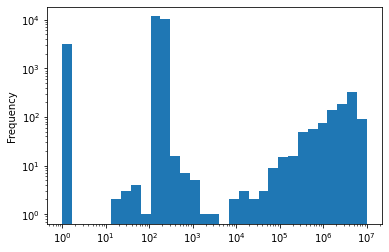

In [600]:
fig, axs = mpl.pyplot.subplots(1)
abs(start_offset).plot(ax=axs,bins=numpy.logspace(0, 7, 32), kind='hist', loglog=True)

In [601]:
shorts = pandas.concat([short_plus, short_minus])

### Plot length vs. offset for each feature.

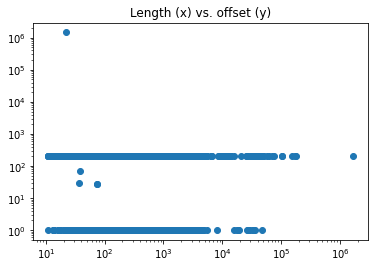

In [602]:
mpl.pyplot.loglog(all_unique.send - all_unique.sstart, start_offset, "o")
_ = mpl.pyplot.title("Length (x) vs. offset (y)")

## Setup the new genome annotation
### Consider only genes

#### Open reference annotations as db

In [603]:
db = gff.FeatureDB('./Pseudomonas_fluorescens_sbw25_ref.db')

### Fix gene, CDS, transcript, mRNA positions
CDS, mRNA are feature.children of gene

In [1]:
from gffutils import biopython_integration as gffbio

In [36]:
### Open the new assembly.

In [647]:
with open("../../../fasta/Pseudomonas_fluorescens_SBW25_28C.fa") as fh:
    new_genome_assembly = next(SeqIO.parse(fh, 'fasta'))

In [649]:
len(new_genome_assembly.seq)

6722400

#### Construct a seq record to append each feature to.

In [655]:
fixed_record = SeqRecord(new_genome_assembly.seq, "MPB ASM001")

#### Loop over the reference annotation features (genes) and their children.
* Get the feature id.
* Adjust start, end position using the subject positions from the blast aligments (stored in the dataframe  `all_unique`).
* Convert feature to SeqFeature.
* Append to SeqRecord

In [668]:
for i,feat in enumerate(db.iter_by_parent_childs(featuretype='gene')):
    # Get id.
    feat_id = feat[0].id
    
    print("Fixing coordinates of gene {} and all its 'children'.".format(feat_id))
    # Retrieve the feature with adjusted coordinates
    fixed_id = feat_id.replace(":", "-") 
    
    # Retrieve the record from the blast alignments.
    fixed_feature = all_unique.loc[fixed_id]
    
    # Loop over all (sub)-features of this one.
    for j,f in enumerate(feat):
        feat[j].start = int(fixed_feature.sstart)
        feat[j].end = int(fixed_feature.send)
    
    # Convert to SeqFeature.
    seq_feature = bpy.to_seqfeature(feat[0])
    seq_feature.sub_features = [bpy.to_seqfeature(f) for f in feat[1:]]
    # Append to the record.     
    fixed_record.features.append(seq_feature)

Fixing coordinates of gene gene:PFLU_0001 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0002 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0003 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0004 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0005 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0006 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0007 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0008 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0009 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0010 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0011 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0012 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0013 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0014 and all its 'children'.
Fixing coordinates of gene gene:PFLU_0015 and all its 'children'.
Fixing coo

### Finally write the new record as gff to disk.

In [669]:
with open("MPB_ASM001_20210401.gff3", "w") as fh:
    GFF.write([fixed_record], fh)